In [2]:
%matplotlib inline

# Import custom scripts

In [3]:
path_scripts = '/Users/simjoo/Projects/STRT_wound/scripts/'

In [4]:
import sys
sys.path.append(path_scripts)

In [5]:
from WND_misc_scripts_v2_0 import *
from WND_neg_binom_regression_v2_0 import *
from WND_pseudotemporal_ordering_v2_0 import *
from WND_outlier_cell_detection_v2_0 import *

# Initialize engines

In [6]:
from ipyparallel import Client

In [7]:
c = Client()

In [8]:
dview = c[:]

In [9]:
dview.execute('import sys')
dview.execute('sys.path.append("/Users/simjoo/Projects/STRT_wound/scripts/")')
dview.execute('from WND_misc_scripts_v2_0 import *')
dview.execute('from WND_affinity_propagation_v2_0 import *')
dview.execute('from WND_neg_binom_regression_v2_0 import *')
dview.execute('from WND_pseudotemporal_ordering_v2_0 import *')
dview.execute('from WND_outlier_cell_detection_v2_0 import *')

<AsyncResult: execute>

# Import Data

In [10]:
exp_id = '201603171136_v2.6'
path_input = '/Users/simjoo/Projects/STRT_wound/data_input/v2.6'
path_output = '/Users/simjoo/Projects/STRT_wound/data_output/v2.6'
path_figures = '/Users/simjoo/Projects/STRT_wound/figures/v2.6'

In [11]:
seq = loadData_v1(path_input, exp_id, 'seq_WND', 'DataFrame')

/Users/simjoo/Projects/STRT_wound/scripts/WND_misc_scripts_v2_0.py:240: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  dataset = pd.DataFrame.from_csv('%s/%s_%s.txt' % (path, id_, name), sep = '\t', header = 0, index_col = 0)


In [12]:
meta = loadData_v1(path_input, exp_id, 'meta_WND', 'DataFrame')

/Users/simjoo/Projects/STRT_wound/scripts/WND_misc_scripts_v2_0.py:240: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  dataset = pd.DataFrame.from_csv('%s/%s_%s.txt' % (path, id_, name), sep = '\t', header = 0, index_col = 0)


In [13]:
meta.ix['Days/Sample'] = ['%s - %s' % (meta.ix['Days',c], meta.ix['Sample', c]) for c in meta.columns];

/Users/simjoo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


# (1) Processing and normalization of data

## Select Tomato-positive cells from Lgr5 and Lgr6 experiments

In [62]:
ix_sel = [c for c in meta.columns if meta.ix['Red',c]=='1.0']

In [63]:
len(ix_sel)

2346

In [15]:
seq_sel = seq[ix_sel]

## Select cells with at least 2000 unique molecules

In [16]:
seq_sel = dropNull_v2(seq_sel, path_input, cutoff_mean = 0.00)


Dropping spikes from dataset

Dropping markers from dataset

Dropping unexpressed genes from dataset


In [17]:
seq_sel = cellCutoff(seq_sel, 2000)


Removing cells with less than 2000 transcripts


In [18]:
len(seq_sel.columns)

1873

In [19]:
seq_sel = dropNull_v2(seq_sel, path_input, cutoff_mean = 0.00, drop_spikes=False, drop_markers=False)


Dropping unexpressed genes from dataset


In [20]:
len(seq_sel.index)

21944

### Checkpoint

In [21]:
#saveData_v1(seq_sel, path_output, exp_id, 'seq_sel')

In [22]:
seq_sel = loadData_v1(path_output, exp_id, 'seq_sel', 'DataFrame')

## Normalize data (including both Lgr5 and Lgr6 dataset)

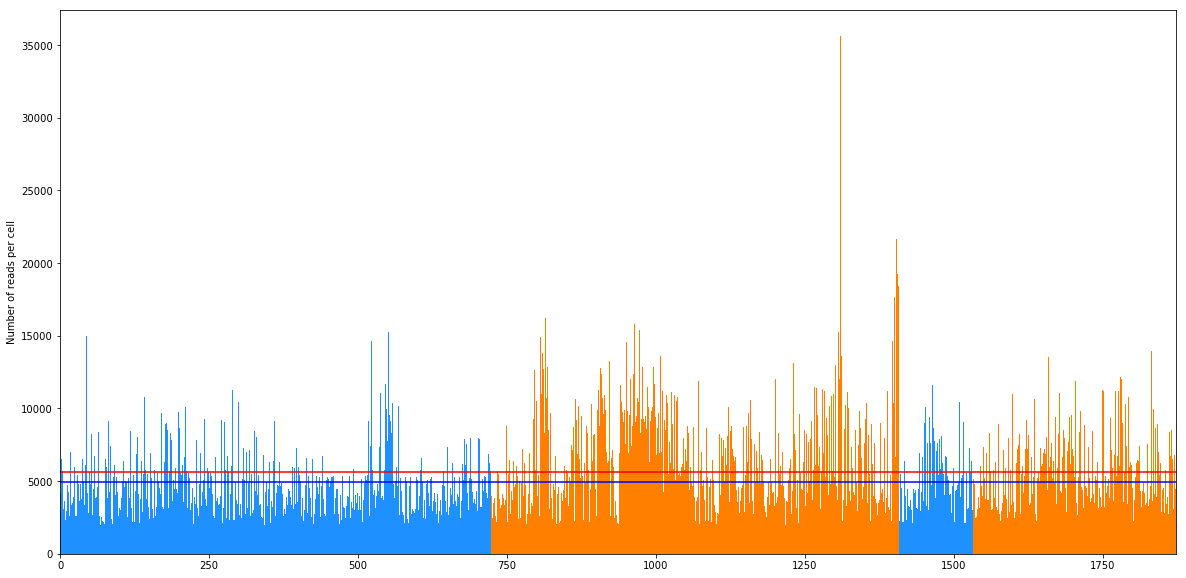

In [23]:
draw_barplots_QC(seq_sel,'reads',meta.ix['Genotype'],{'Lgr5cre/Tomato':'dodgerblue','Lgr6cre/Tomato':'#ff7f00'})


Dropping unexpressed genes from dataset

After mean expression cutoff of 0.5, 1711 genes remain
Optimization terminated successfully.
         Current function value: 304.702057
         Iterations: 29
         Function evaluations: 53

After high variance feature selection, 0 genes remain

Calculating binary logarithm of x + 1


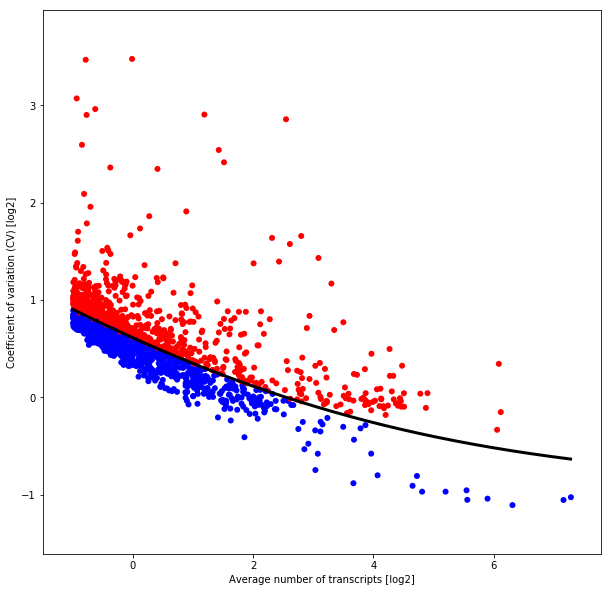

In [24]:
genes_sel_diff = select_features_v3(seq_sel, 0.5, -2000, path_input, return_all=True, drop_spikes = False, drop_markers = False)[1]

In [25]:
genes_sel = genes_sel_diff[genes_sel_diff<0].index

In [26]:
len(genes_sel)

865

In [27]:
sf = get_size_factors(seq_sel.ix[genes_sel])

In [28]:
seq_sel_norm = seq_sel / sf

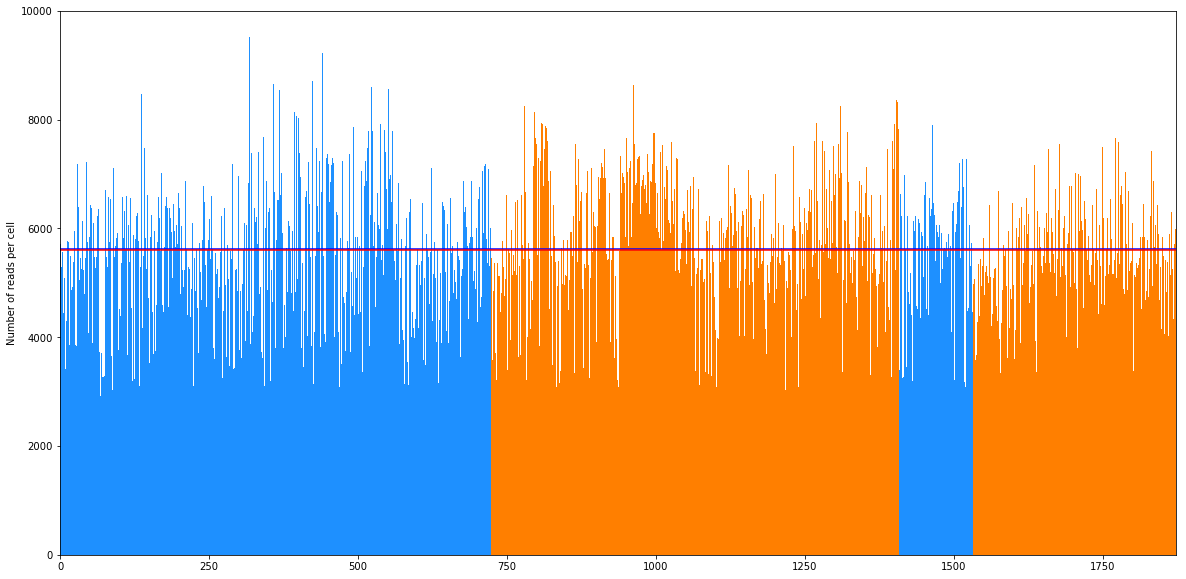

In [29]:
draw_barplots_QC(seq_sel_norm,'reads',meta.ix['Genotype'],{'Lgr5cre/Tomato':'dodgerblue','Lgr6cre/Tomato':'#ff7f00'})

### Checkpoint

In [30]:
#saveData_v1(sf, path_output, exp_id, 'sf')
#saveData_v1(seq_sel_norm, path_output, exp_id, 'seq_sel_norm')

In [31]:
seq_sel_norm = loadData_v1(path_output, exp_id, 'seq_sel_norm', 'DataFrame')

# (2) Wound cell detection in Lgr5/Tomato samples

## Select Tomato-positive cells from Lgr5 experiments

In [32]:
ix_Lgr5 = [c for c in seq_sel_norm.columns if meta.ix['Genotype',c]=='Lgr5cre/Tomato']

In [33]:
len(ix_Lgr5)

847

In [34]:
seq_sel_Lgr5 = seq_sel[ix_Lgr5]

### Checkpoint

In [35]:
saveData_v1(seq_sel_Lgr5, path_output, exp_id, 'seq_sel_Lgr5')

In [36]:
seq_sel_Lgr5 = loadData_v1(path_output, exp_id, 'seq_sel_Lgr5', 'DataFrame')

## Normalize Lgr5 dataset

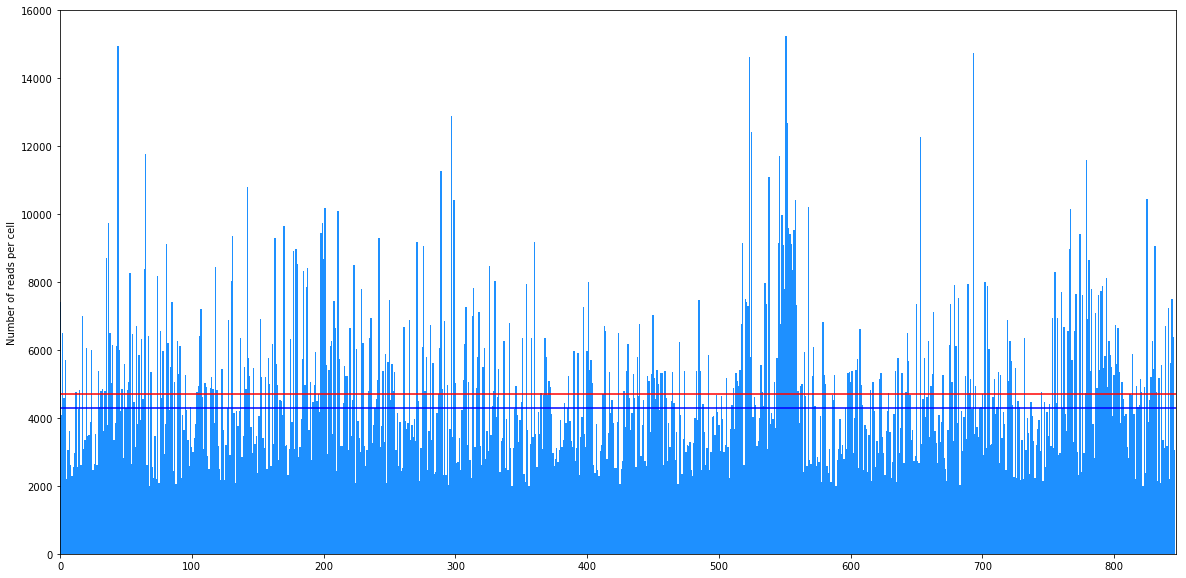

In [37]:
draw_barplots_QC(seq_sel_Lgr5,'reads',meta.ix['Genotype'],{'Lgr5cre/Tomato':'dodgerblue','Lgr6cre/Tomato':'#ff7f00'})


Dropping unexpressed genes from dataset

After mean expression cutoff of 0.5, 1437 genes remain
Optimization terminated successfully.
         Current function value: 239.019525
         Iterations: 30
         Function evaluations: 56

After high variance feature selection, 0 genes remain

Calculating binary logarithm of x + 1


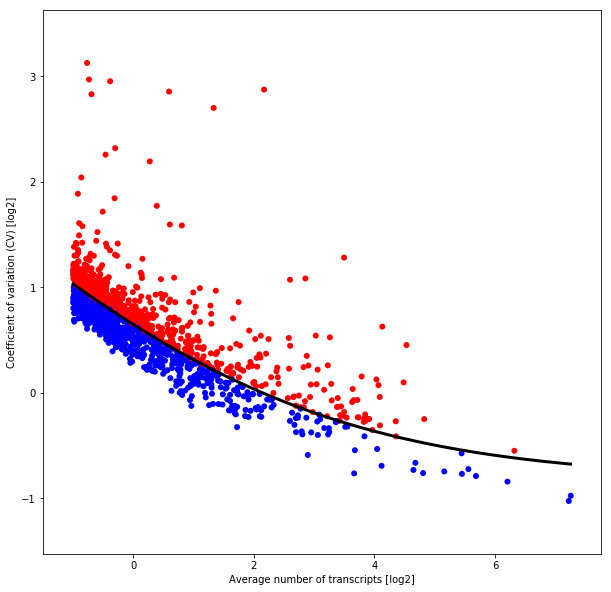

In [38]:
genes_sel_diff_Lgr5 = select_features_v3(seq_sel_Lgr5, 0.5, -2000, path_input, return_all=True, drop_spikes = False, drop_markers = False)[1]

In [39]:
genes_sel_Lgr5 = genes_sel_diff_Lgr5[genes_sel_diff_Lgr5<0].index

In [40]:
len(genes_sel_Lgr5)

723

In [41]:
sf_Lgr5 = get_size_factors(seq_sel_Lgr5.ix[genes_sel_Lgr5])

In [42]:
seq_sel_Lgr5_norm = seq_sel_Lgr5 / sf_Lgr5

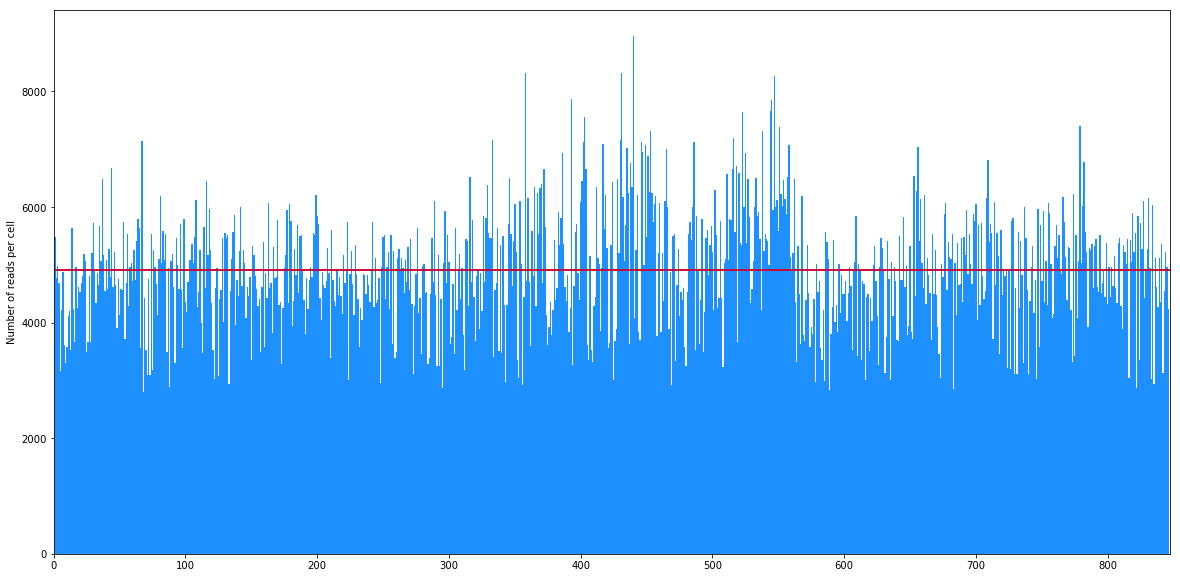

In [43]:
draw_barplots_QC(seq_sel_Lgr5_norm,'reads',meta.ix['Genotype'],{'Lgr5cre/Tomato':'dodgerblue','Lgr6cre/Tomato':'#ff7f00'})

### Checkpoint

In [44]:
#saveData_v1(seq_sel_Lgr5_norm, path_output, exp_id, 'seq_sel_Lgr5_norm')

In [17]:
seq_sel_Lgr5_norm = loadData_v1(path_output, exp_id, 'seq_sel_Lgr5_norm', 'DataFrame')

/Users/simjoo/Projects/STRT_wound/scripts/WND_misc_scripts_v2_0.py:240: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  dataset = pd.DataFrame.from_csv('%s/%s_%s.txt' % (path, id_, name), sep = '\t', header = 0, index_col = 0)


## Define cell selection matrix

In [18]:
#select 0 day control cells

c_sel_0d_ctrl_Lgr5 = []

for c in seq_sel_Lgr5_norm.columns:
    if meta.ix['Days', c] == '0 d':
        c_sel_0d_ctrl_Lgr5.append(c)

In [19]:
#select 1 day - >1 month wound area cells 

c_sel_ctrl_area_Lgr5 = []

for c in seq_sel_Lgr5_norm.columns:
    if meta.ix['Days', c] != '0 d' and meta.ix['Sample',c] == 'ctrl':
        c_sel_ctrl_area_Lgr5.append(c)

In [20]:
#select 1 day - >1 month control area cells 

c_sel_wnd_area_Lgr5 = []

for c in seq_sel_Lgr5_norm.columns:
    if meta.ix['Days', c] != '0 d' and meta.ix['Sample',c] == 'wnd':
        c_sel_wnd_area_Lgr5.append(c)

In [21]:
cells_Lgr5 = pd.Series(0, index = c_sel_0d_ctrl_Lgr5 + c_sel_ctrl_area_Lgr5 + c_sel_wnd_area_Lgr5)
cells_Lgr5[c_sel_ctrl_area_Lgr5] = 1
cells_Lgr5[c_sel_wnd_area_Lgr5] = 1

### Checkpoint

In [50]:
#saveData_v1(cells_Lgr5, path_output, exp_id, 'cells_Lgr5')

In [22]:
cells_Lgr5 = loadData_v1(path_output, exp_id, 'cells_Lgr5', 'Series')

/Users/simjoo/anaconda/lib/python3.6/site-packages/pandas/core/series.py:2890: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  infer_datetime_format=infer_datetime_format)


## Model control gene expression and compare to wound samples

In [52]:
genes_sel_Lgr5 = list(dropNull_v2(seq_sel_Lgr5_norm, path_input, cutoff_mean = 0.1, drop_markers=False, drop_spikes=False).index)


Dropping unexpressed genes from dataset


In [53]:
len(genes_sel_Lgr5)

6509

In [54]:
#outlier_pval_Lgr5 = OD_detect_outliers_v2P(np.rint(seq_sel_Lgr5_norm), cells_Lgr5, dview, path_input, genes_sel_Lgr5, 
                                           #cutoff_mean = None, score_ctrl = False, BH = False, neg_log = True)

In [55]:
#outlier_loocv_Lgr5 = OD_loocv_v2P(np.rint(seq_sel_Lgr5_norm), cells_Lgr5, genes_sel_Lgr5, dview, BH = False, neg_log = True)

### Checkpoint

In [56]:
#saveData_to_pickle_v1(outlier_pval_Lgr5, path_output, exp_id, 'outlier_pval_Lgr5')
#saveData_to_pickle_v1(outlier_loocv_Lgr5, path_output, exp_id, 'outlier_loocv_Lgr5')

In [14]:
outlier_pval_Lgr5 = loadData_from_pickle_v1(path_output, exp_id, 'outlier_pval_Lgr5')
outlier_loocv_Lgr5 = loadData_from_pickle_v1(path_output, exp_id, 'outlier_loocv_Lgr5')

## Select features

In [23]:
alpha = -np.log10(0.01)
n = 5
ratio = len(c_sel_wnd_area_Lgr5) / len(c_sel_ctrl_area_Lgr5)

In [24]:
genes_cnt_Lgr5_ctrl = (outlier_pval_Lgr5[c_sel_ctrl_area_Lgr5]>=alpha).sum(axis=1)
genes_cnt_Lgr5_wnd = (outlier_pval_Lgr5[c_sel_wnd_area_Lgr5]>=alpha).sum(axis=1)

In [25]:
genes_sel_Lgr5 = genes_cnt_Lgr5_wnd[genes_cnt_Lgr5_wnd>=n].index

In [26]:
len(genes_sel_Lgr5)

864

In [27]:
genes_SNr_Lgr5 = genes_cnt_Lgr5_wnd[genes_sel_Lgr5] / genes_cnt_Lgr5_ctrl[genes_sel_Lgr5]

In [28]:
genes_sel_Lgr5 = genes_SNr_Lgr5[genes_SNr_Lgr5>ratio*1.5].index

In [31]:
len(genes_sel_Lgr5)

306

In [32]:
outlier_pval_Lgr5_sel = outlier_pval_Lgr5.ix[genes_sel_Lgr5]
outlier_loocv_Lgr5_sel = outlier_loocv_Lgr5.ix[genes_sel_Lgr5]

/Users/simjoo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.
/Users/simjoo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


### Checkpoint

In [348]:
#saveData_v1(outlier_pval_Lgr5_sel, path_output, exp_id, 'outlier_pval_Lgr5_sel')
#saveData_v1(outlier_loocv_Lgr5_sel, path_output, exp_id, 'outlier_loocv_Lgr5_sel')

In [349]:
outlier_pval_Lgr5_sel = loadData_v1(path_output, exp_id, 'outlier_pval_Lgr5_sel', 'DataFrame')
outlier_loocv_Lgr5_sel = loadData_v1(path_output, exp_id, 'outlier_loocv_Lgr5_sel', 'DataFrame')

/Users/simjoo/Projects/STRT_wound/scripts/WND_misc_scripts_v2_0.py:240: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  dataset = pd.DataFrame.from_csv('%s/%s_%s.txt' % (path, id_, name), sep = '\t', header = 0, index_col = 0)


## Select wound cells with significantly different gene expression based on all selected genes

In [66]:
cells_Lgr5_tmp = pd.Series(0, index = outlier_pval_Lgr5_sel.columns)

In [67]:
cutoff = np.percentile(outlier_loocv_Lgr5_sel.sum(axis=0), 100)

In [68]:
cutoff = 75

In [69]:
#print(cutoff)

In [70]:
c_wnd = outlier_pval_Lgr5_sel.sum(axis=0)[outlier_pval_Lgr5_sel.sum(axis=0) > cutoff].index

In [71]:
len(c_wnd)

140

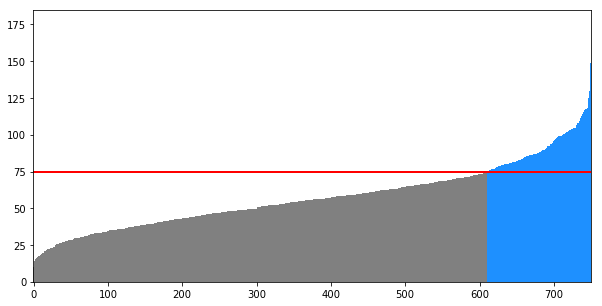

In [72]:
OD_plot_diff_genes_per_cell(outlier_pval_Lgr5_sel, cutoff, order = True)

In [73]:
cells_Lgr5_tmp[c_wnd] = 1

In [74]:
Counter(meta.ix['Days/Sample', c_wnd])

Counter({'1 d - wnd': 60,
         '1 m+ - ctrl': 12,
         '1 m+ - wnd': 21,
         '10 d - wnd': 17,
         '4 d - wnd': 11,
         '7 d - ctrl': 1,
         '7 d - wnd': 18})

In [75]:
cells_Lgr5_ctrl_all = pd.Series([meta.ix['Days',c] for c in c_wnd if meta.ix['Sample',c] == 'ctrl'],
                                index = [c for c in c_wnd if meta.ix['Sample',c] == 'ctrl'])

In [76]:
Counter(cells_Lgr5_ctrl_all)

Counter({'1 m+': 12, '7 d': 1})

In [77]:
cells_Lgr5_wnd_all = pd.Series([meta.ix['Days',c] for c in c_wnd if meta.ix['Sample',c] == 'wnd'],
                                index = [c for c in c_wnd if meta.ix['Sample',c] == 'wnd'])

In [78]:
Counter(cells_Lgr5_wnd_all)

Counter({'1 d': 60, '1 m+': 21, '10 d': 17, '4 d': 11, '7 d': 18})

In [79]:
get_enrichment(meta, cells_Lgr5_ctrl_all.index, c_sel_ctrl_area_Lgr5, 
                   cells_Lgr5_wnd_all.index, c_sel_wnd_area_Lgr5)

count - ctrl perc - ctrl count - wnd perc - wnd   pval - wnd
1 d             0           0          60   0.289855            0
4 d             0           0          11   0.148649            0
7 d             1    0.027027          18   0.171429  5.00608e-10
10 d            0           0          17   0.180851            0
1 m+           12       0.375          21   0.287671     0.953975

### The number of selected cells in the 1m+ wnd population is not significantly different from the control population ==> do not include selected 1m wound cells

## Combine wound cells 

In [80]:
cells_Lgr5_wnd = pd.Series()

for c in cells_Lgr5_wnd_all[~cells_Lgr5_wnd_all.isin(['1 m+'])].index:
    cells_Lgr5_wnd[c] = cells_Lgr5_wnd_all[c]

In [81]:
len(cells_Lgr5_wnd)

106

In [82]:
Counter(cells_Lgr5_wnd)

Counter({'1 d': 60, '10 d': 17, '4 d': 11, '7 d': 18})

### Checkpoint

In [83]:
#saveData_v1(cells_Lgr5_wnd, path_output, exp_id, 'cells_Lgr5_wnd')

In [84]:
cells_Lgr5_wnd = loadData_v1(path_output, exp_id, 'cells_Lgr5_wnd', 'Series')

## Add all 0-day control cells to Lgr5 wound cells

In [102]:
cells_Lgr5_wnd_ctrl = cells_Lgr5_wnd.copy()

for c in c_sel_0d_ctrl_Lgr5:
    cells_Lgr5_wnd_ctrl[c] = '0 d'

In [103]:
Counter(cells_Lgr5_wnd_ctrl)

Counter({'0 d': 96, '1 d': 60, '10 d': 17, '4 d': 11, '7 d': 18})

### Checkpoint

In [104]:
saveData_v1(cells_Lgr5_wnd_ctrl, path_output, exp_id, 'cells_Lgr5_wnd_ctrl')

In [105]:
cells_Lgr5_wnd_ctrl = loadData_v1(path_output, exp_id, 'cells_Lgr5_wnd_ctrl', 'Series')

## Randomly select 25 0-day control cells for downstream analysis to ensure that downstream analysis is not dominated by 0-day control

In [106]:
c_sel = list(cells_Lgr5_wnd_ctrl[cells_Lgr5_wnd_ctrl!='0 d'].index) + list(np.random.choice(cells_Lgr5_wnd_ctrl[cells_Lgr5_wnd_ctrl=='0 d'].index, 25, replace = False))

In [107]:
cells_Lgr5_wnd_ctrl_sel = cells_Lgr5_wnd_ctrl[c_sel]

In [108]:
Counter(cells_Lgr5_wnd_ctrl_sel)

Counter({'0 d': 25, '1 d': 60, '10 d': 17, '4 d': 11, '7 d': 18})

### Checkpoint

In [109]:
#saveData_v1(cells_Lgr5_wnd_ctrl_sel, path_output, exp_id, 'cells_Lgr5_wnd_ctrl_sel')

In [110]:
cells_Lgr5_wnd_ctrl_sel = loadData_v1(path_output, exp_id, 'cells_Lgr5_wnd_ctrl_sel', 'Series')

# (3) tSNE visualization and clustering of Lgr5 wound cells

## Feature selection


Dropping unexpressed genes from dataset

After mean expression cutoff of 0.2, 4471 genes remain
Optimization terminated successfully.
         Current function value: 1006.800097
         Iterations: 28
         Function evaluations: 55

After high variance feature selection, 1000 genes remain

Calculating binary logarithm of x + 1


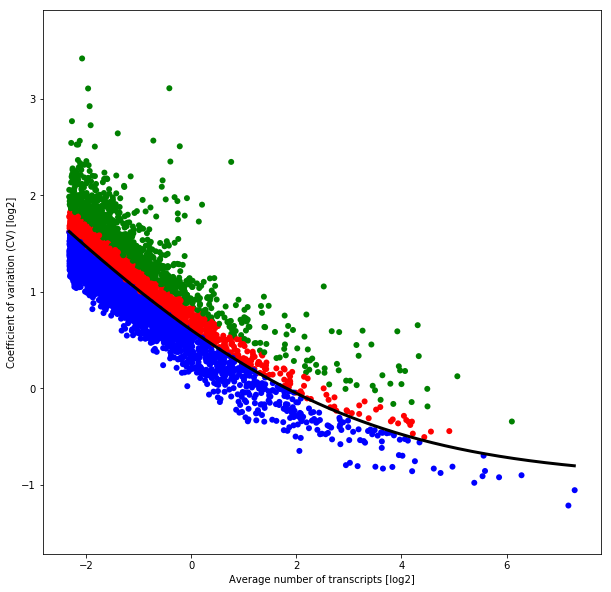

In [151]:
seq_sel_Lgr5_wnd = select_features_v3(seq_sel_Lgr5_norm[cells_Lgr5_wnd_ctrl_sel.index], 0.2, 1000, path_input, return_all=False, drop_spikes = False, drop_markers = False)

### Checkpoint

In [152]:
#saveData_v1(seq_sel_Lgr5_wnd, path_output, exp_id, 'seq_sel_Lgr5_wnd')

In [25]:
seq_sel_Lgr5_wnd = loadData_v1(path_output, exp_id, 'seq_sel_Lgr5_wnd', 'DataFrame')

/Users/simjoo/Projects/STRT_wound/scripts/WND_misc_scripts_v2_0.py:240: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  dataset = pd.DataFrame.from_csv('%s/%s_%s.txt' % (path, id_, name), sep = '\t', header = 0, index_col = 0)


## tSNE

In [451]:
seq_sel_Lgr5_pca, dist_Lgr5_pca = dist_mat_dim_reduc_v2(seq_sel_Lgr5_wnd, dim=4, method='NMF', distance = 'euclidean')

/Users/simjoo/anaconda/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['Liberation Sans'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


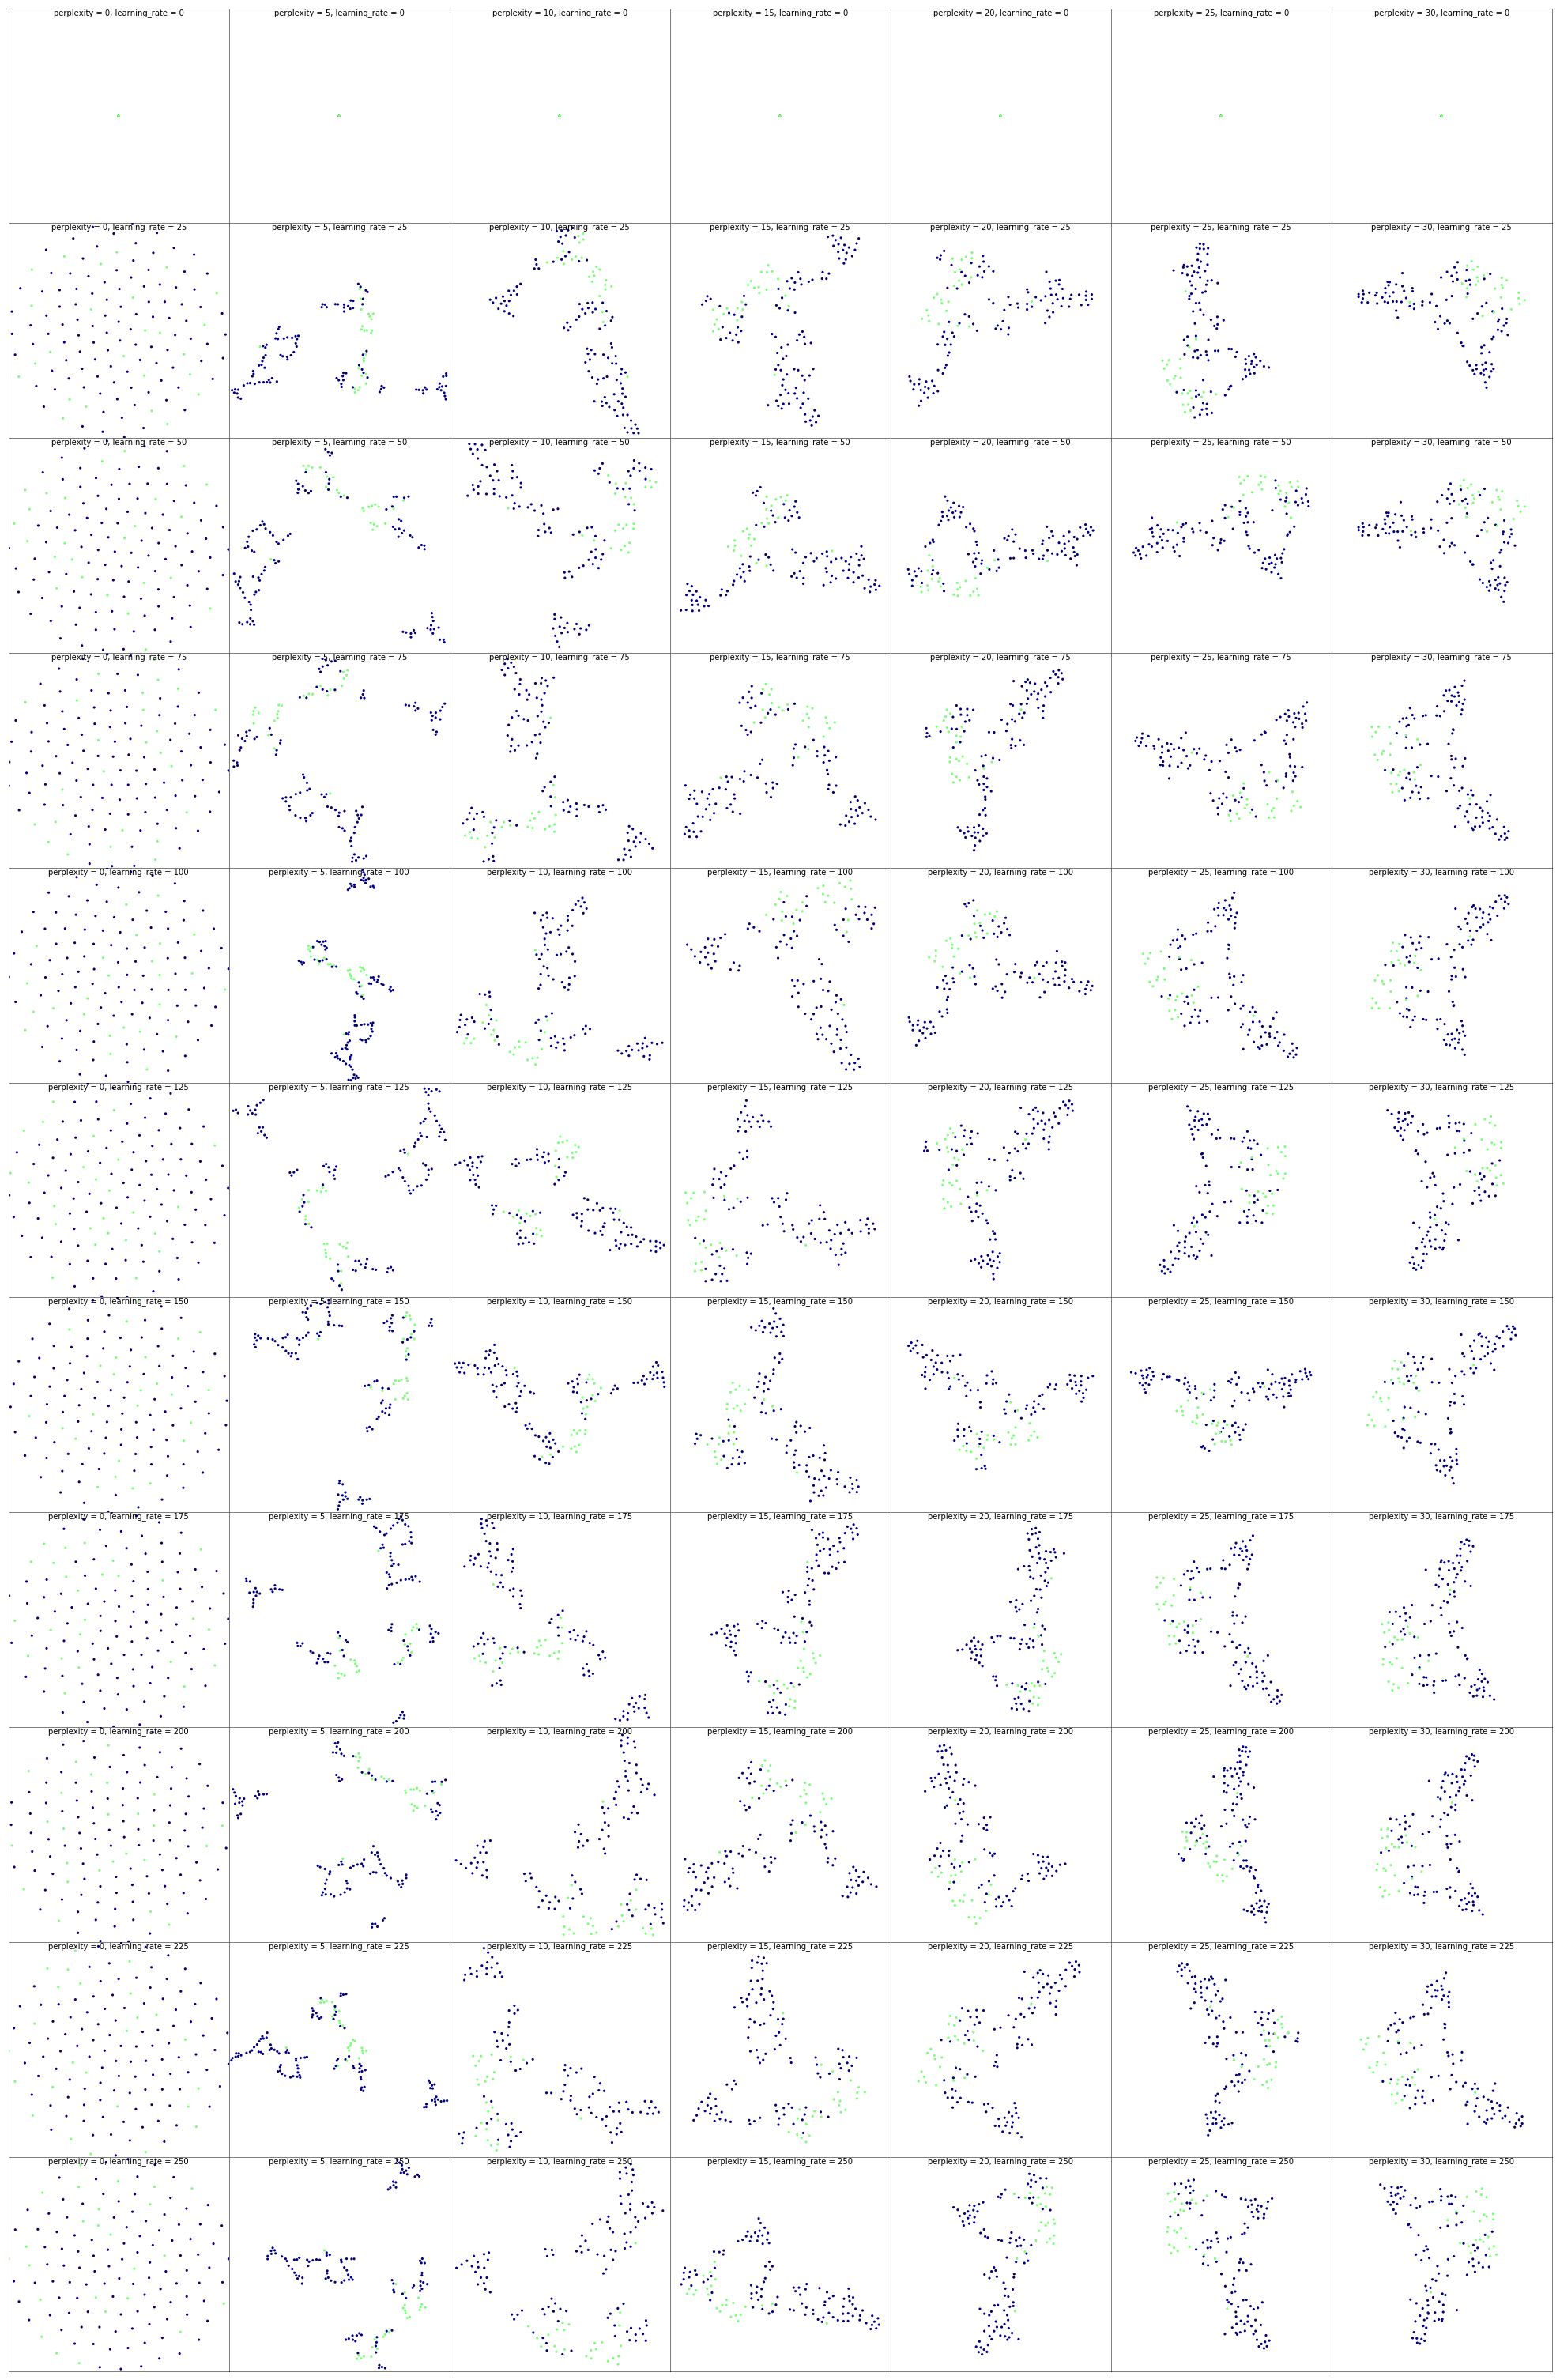

In [452]:
tsne_coords_Lgr5 = tSNE_get_params_v1P(dist_Lgr5_pca, 
                                       cells_Lgr5[cells_Lgr5_wnd_ctrl_sel.index], 
                                       plt.cm.jet,
                                       dview,
                                       np.arange(0,35,5),
                                       2.0,
                                       np.arange(0,275,25),
                                       10000,
                                       sec_var = 'learning_rate')

In [455]:
tsne_Lgr5_wnd_ctrl_sel = tsne_coords_Lgr5[(20,150)]

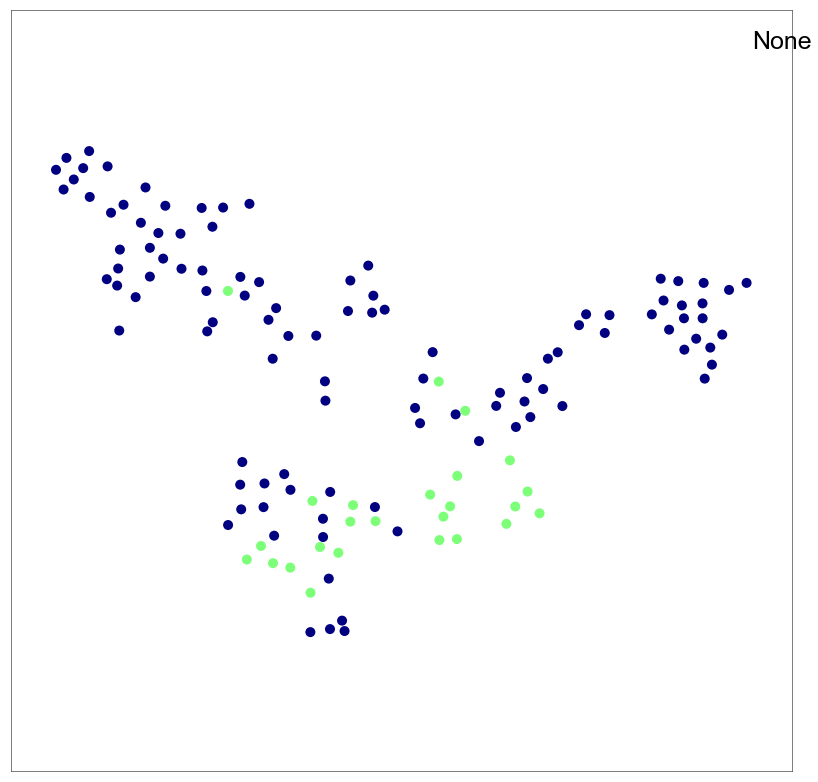

In [456]:
draw_tSNE(tsne_Lgr5_wnd_ctrl_sel, cells_Lgr5[cells_Lgr5_wnd_ctrl_sel.index])

### Checkpoint

In [457]:
#saveData_v1(tsne_Lgr5_wnd_ctrl_sel, path_output, exp_id, 'tsne_Lgr5_wnd_ctrl_sel')

In [458]:
tsne_Lgr5_wnd_ctrl_sel = loadData_v1(path_output, exp_id, 'tsne_Lgr5_wnd_ctrl_sel', 'DataFrame')

## k-means clustering of wound cells

/Users/simjoo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  import sys


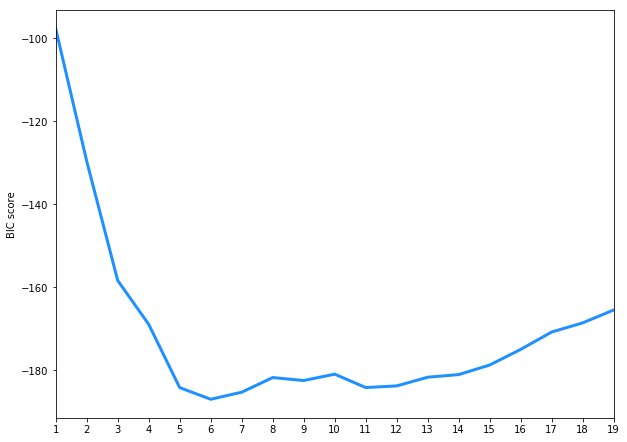

In [462]:
tsne_kmeans_select_n(seq_sel_Lgr5_pca,
                     tsne_Lgr5_wnd_ctrl_sel, 
                     cells_Lgr5_wnd.index, 
                     range(1,20), 
                     criterion = 'BIC')

In [463]:
cl_Lgr5_wnd = tsne_kmeans(tsne_Lgr5_wnd_ctrl_sel, cells_Lgr5_wnd.index, 6)

## Combine groups 2 + 5 (mostly similar WF cells) and move Krt6a(lo) / Krt14 (hi) to group 1

In [486]:
cl_Lgr5_wnd[cl_Lgr5_wnd==5] = 2

In [496]:
c_sel = ['1772117135-C03','1772117082-H08','1772122233-D09','1772117128-C02','1772117081-B11','1772122234-A12']
cl_Lgr5_wnd[c_sel] = 1

In [497]:
cl_Lgr5_wnd = AP_reorder_inclusters(seq_sel_Lgr5_pca, cl_Lgr5_wnd, 0, linkage='single')

/Users/simjoo/Projects/STRT_wound/scripts/WND_affinity_propagation_v2_0.py:745: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  tmp_Z = sch.linkage(tmp_dist, method = linkage)


## Add 0 day control cells

In [498]:
cl_Lgr5_wnd_ctrl = cl_Lgr5_wnd.copy()

for c in c_sel_0d_ctrl_Lgr5:
    cl_Lgr5_wnd_ctrl[c] = 'ctrl'

## Add randomly selected 0 day control cells

In [499]:
cl_Lgr5_wnd_ctrl_sel = cl_Lgr5_wnd.copy()

for c in cells_Lgr5_wnd_ctrl_sel[cells_Lgr5_wnd_ctrl_sel=='0 d'].index:
    cl_Lgr5_wnd_ctrl_sel[c] = 'ctrl'

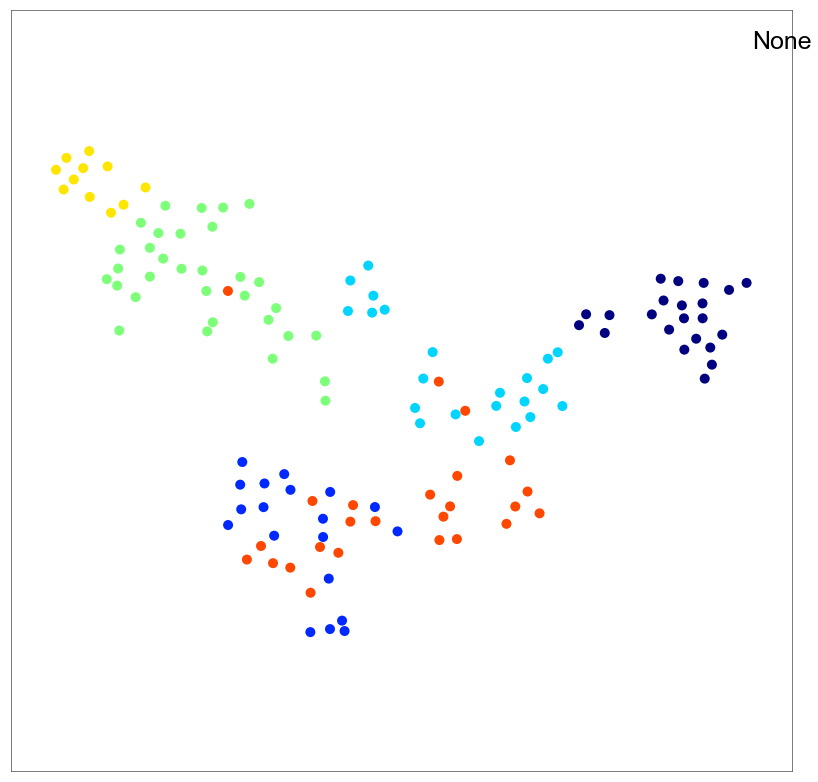

In [500]:
draw_tSNE(tsne_Lgr5_wnd_ctrl_sel, cl_Lgr5_wnd_ctrl_sel)

### Checkpoint

In [502]:
#saveData_v1(cl_Lgr5_wnd, path_output, exp_id, 'cl_Lgr5_wnd')
#saveData_v1(cl_Lgr5_wnd_ctrl, path_output, exp_id, 'cl_Lgr5_wnd_ctrl')
#saveData_v1(cl_Lgr5_wnd_ctrl_sel, path_output, exp_id, 'cl_Lgr5_wnd_ctrl_sel')
#saveData_v1(tsne_Lgr5_wnd_ctrl_sel.ix[cl_Lgr5_wnd_ctrl_sel.index], path_output, exp_id, 'tsne_Lgr5_wnd_ctrl_sel')

In [102]:
cl_Lgr5_wnd = loadData_v1(path_output, exp_id, 'cl_Lgr5_wnd', 'Series')
cl_Lgr5_wnd_ctrl = loadData_v1(path_output, exp_id, 'cl_Lgr5_wnd_ctrl', 'Series')
cl_Lgr5_wnd_ctrl_sel = loadData_v1(path_output, exp_id, 'cl_Lgr5_wnd_ctrl_sel', 'Series')

/Users/simjoo/anaconda/lib/python3.6/site-packages/pandas/core/series.py:2849: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  infer_datetime_format=infer_datetime_format)


# (4) Wound cell detection in Lgr6/Tomato samples

## Select Tomato-positive cells from Lgr6 experiments

In [231]:
ix_Lgr6 = [c for c in seq_sel_norm.columns if meta.ix['Genotype',c]=='Lgr6cre/Tomato']

In [232]:
len(ix_Lgr6)

1026

In [233]:
seq_sel_Lgr6 = seq_sel[ix_Lgr6]

### Checkpoint

In [234]:
#saveData_v1(seq_sel_Lgr6, path_output, exp_id, 'seq_sel_Lgr6')

In [235]:
seq_sel_Lgr6 = loadData_v1(path_output, exp_id, 'seq_sel_Lgr6', 'DataFrame')

## Normalize Lgr6 dataset

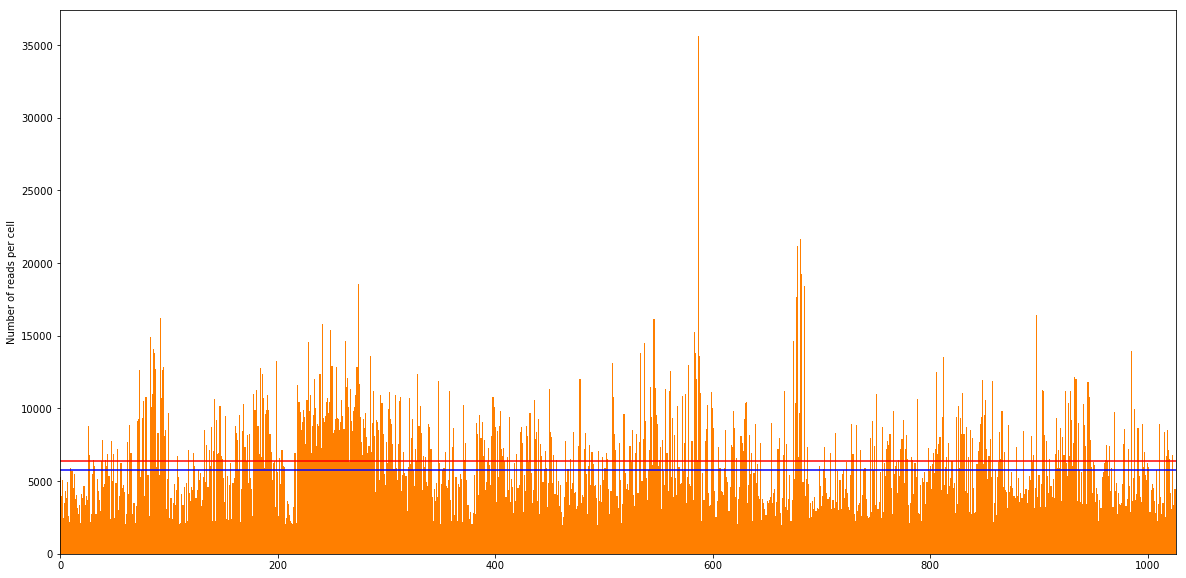

In [236]:
draw_barplots_QC(seq_sel_Lgr6,'reads',meta.ix['Genotype'],{'Lgr5cre/Tomato':'dodgerblue','Lgr6cre/Tomato':'#ff7f00'})


Dropping unexpressed genes from dataset

After mean expression cutoff of 0.5, 1921 genes remain
Optimization terminated successfully.
         Current function value: 321.604012
         Iterations: 34
         Function evaluations: 64

After high variance feature selection, 0 genes remain

Calculating binary logarithm of x + 1


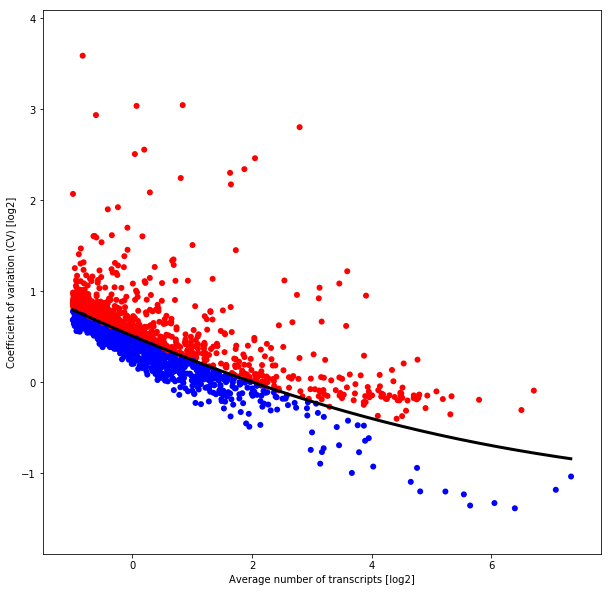

In [237]:
genes_sel_diff_Lgr6 = select_features_v3(seq_sel_Lgr6, 0.5, -2000, path_input, return_all=True, drop_spikes = False, drop_markers = False)[1]

In [238]:
genes_sel_Lgr6 = genes_sel_diff_Lgr6[genes_sel_diff_Lgr6<0].index

In [239]:
len(genes_sel_Lgr6)

973

In [240]:
sf_Lgr6 = get_size_factors(seq_sel_Lgr6.ix[genes_sel_Lgr6])

In [241]:
seq_sel_Lgr6_norm = seq_sel_Lgr6 / sf_Lgr6

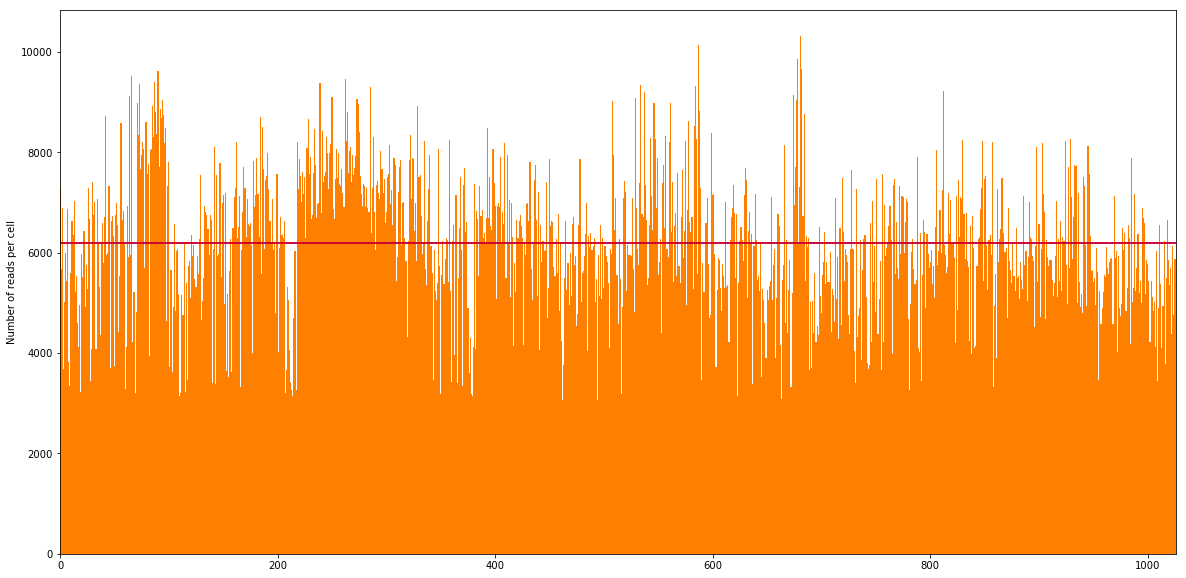

In [242]:
draw_barplots_QC(seq_sel_Lgr6_norm,'reads',meta.ix['Genotype'],{'Lgr5cre/Tomato':'dodgerblue','Lgr6cre/Tomato':'#ff7f00'})

### Checkpoint

In [243]:
#saveData_v1(seq_sel_Lgr6_norm, path_output, exp_id, 'seq_sel_Lgr6_norm')

In [38]:
seq_sel_Lgr6_norm = loadData_v1(path_output, exp_id, 'seq_sel_Lgr6_norm', 'DataFrame')

/Users/simjoo/Projects/STRT_wound/scripts/WND_misc_scripts_v2_0.py:240: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  dataset = pd.DataFrame.from_csv('%s/%s_%s.txt' % (path, id_, name), sep = '\t', header = 0, index_col = 0)


## Define control (0 day) and wound sample cells (1d - >1m)

In [39]:
#select 0 day control cells

c_sel_0d_ctrl_Lgr6 = []

for c in seq_sel_Lgr6_norm.columns:
    if meta.ix['Days', c] == '0 d':
        c_sel_0d_ctrl_Lgr6.append(c)

In [40]:
#select 1 day - >1 month control area cells 

c_sel_ctrl_area_Lgr6 = []

for c in seq_sel_Lgr6_norm.columns:
    if meta.ix['Days', c] != '0 d' and meta.ix['Sample',c] == 'ctrl':
        c_sel_ctrl_area_Lgr6.append(c)

In [41]:
#select 1 day - >1 month wound area cells 

c_sel_wnd_area_Lgr6 = []

for c in seq_sel_Lgr6_norm.columns:
    if meta.ix['Days', c] != '0 d' and meta.ix['Sample',c] == 'wnd':
        c_sel_wnd_area_Lgr6.append(c)

In [42]:
cells_Lgr6 = pd.Series(0, index = c_sel_0d_ctrl_Lgr6 + c_sel_ctrl_area_Lgr6 + c_sel_wnd_area_Lgr6)
cells_Lgr6[c_sel_ctrl_area_Lgr6] = 1
cells_Lgr6[c_sel_wnd_area_Lgr6] = 1

### Checkpoint

In [249]:
#saveData_v1(cells_Lgr6, path_output, exp_id, 'cells_Lgr6')

In [250]:
cells_Lgr6 = loadData_v1(path_output, exp_id, 'cells_Lgr6', 'Series')

## Identify isthmus 0-day control cells based on a priori-defined markers

In [251]:
cells_Lgr6_0d_ctrl = pd.Series('ctrl - IFE', index = c_sel_0d_ctrl_Lgr6)

cells_Lgr6_0d_ctrl[seq_sel_Lgr6_norm.ix['Krt79',c_sel_0d_ctrl_Lgr6][seq_sel_Lgr6_norm.ix['Krt79',c_sel_0d_ctrl_Lgr6]>=10].index] = 'ctrl - IST'
cells_Lgr6_0d_ctrl[seq_sel_Lgr6_norm.ix['Krt17',c_sel_0d_ctrl_Lgr6][seq_sel_Lgr6_norm.ix['Krt17',c_sel_0d_ctrl_Lgr6]>=20].index] = 'ctrl - IST'
cells_Lgr6_0d_ctrl[seq_sel_Lgr6_norm.ix['Fst',c_sel_0d_ctrl_Lgr6][seq_sel_Lgr6_norm.ix['Fst',c_sel_0d_ctrl_Lgr6]>=3].index] = 'ctrl - IST'
cells_Lgr6_0d_ctrl[seq_sel_Lgr6_norm.ix['Sox9',c_sel_0d_ctrl_Lgr6][seq_sel_Lgr6_norm.ix['Sox9',c_sel_0d_ctrl_Lgr6]>=3].index] = 'ctrl - IST'

/Users/simjoo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until


In [252]:
Counter(cells_Lgr6_0d_ctrl)

Counter({'ctrl - IFE': 130, 'ctrl - IST': 24})

In [253]:
cells_Lgr6_IFE = pd.Series(0, index = list(cells_Lgr6_0d_ctrl[cells_Lgr6_0d_ctrl=='ctrl - IFE'].index) + c_sel_ctrl_area_Lgr6 + c_sel_wnd_area_Lgr6)
cells_Lgr6_IFE[c_sel_ctrl_area_Lgr6] = 1
cells_Lgr6_IFE[c_sel_wnd_area_Lgr6] = 1

In [254]:
Counter(cells_Lgr6_IFE)

Counter({0: 130, 1: 872})

In [255]:
cells_Lgr6_IST = pd.Series(0, index = list(cells_Lgr6_0d_ctrl[cells_Lgr6_0d_ctrl=='ctrl - IST'].index) + c_sel_ctrl_area_Lgr6 + c_sel_wnd_area_Lgr6)
cells_Lgr6_IST[c_sel_ctrl_area_Lgr6] = 1
cells_Lgr6_IST[c_sel_wnd_area_Lgr6] = 1

In [256]:
Counter(cells_Lgr6_IST)

Counter({0: 24, 1: 872})

### Checkpoint

In [257]:
#saveData_v1(cells_Lgr6_0d_ctrl, path_output, exp_id, 'cells_Lgr6_0d_ctrl')
#saveData_v1(cells_Lgr6_IFE, path_output, exp_id, 'cells_Lgr6_IFE')
#saveData_v1(cells_Lgr6_IST, path_output, exp_id, 'cells_Lgr6_IST')

In [258]:
cells_Lgr6_0d_ctrl = loadData_v1(path_output, exp_id, 'cells_Lgr6_0d_ctrl', 'Series')
cells_Lgr6_IFE = loadData_v1(path_output, exp_id, 'cells_Lgr6_IFE', 'Series')
cells_Lgr6_IST = loadData_v1(path_output, exp_id, 'cells_Lgr6_IST', 'Series')

## Model control gene expression and compare to wound samples

In [259]:
genes_sel_Lgr6_IFE = list(dropNull_v2(seq_sel_Lgr6_norm[cells_Lgr6_IFE.index], path_input, cutoff_mean = 0.1, drop_markers=False, drop_spikes=False).index)


Dropping unexpressed genes from dataset


In [260]:
len(genes_sel_Lgr6_IFE)

6876

In [261]:
#outlier_pval_Lgr6_IFE = OD_detect_outliers_v2P(np.rint(seq_sel_Lgr6_norm), cells_Lgr6_IFE, dview, path_input, genes_sel_Lgr6_IFE, 
                                               #cutoff_mean = None, score_ctrl = False, BH = False, neg_log = True)

In [262]:
#outlier_loocv_Lgr6_IFE = OD_loocv_v2P(np.rint(seq_sel_Lgr6_norm), cells_Lgr6_IFE, genes_sel_Lgr6_IFE, dview, BH = False, neg_log = True)

In [263]:
genes_sel_Lgr6_IST = list(dropNull_v2(seq_sel_Lgr6_norm[cells_Lgr6_IST.index], path_input, cutoff_mean = 0.1, drop_markers=False, drop_spikes=False).index)


Dropping unexpressed genes from dataset


In [264]:
len(genes_sel_Lgr6_IST)

6889

In [265]:
#outlier_pval_Lgr6_IST = OD_detect_outliers_v2P(np.rint(seq_sel_Lgr6_norm), cells_Lgr6_IST, dview, path_input, genes_sel_Lgr6_IST, 
                                               #cutoff_mean = None, score_ctrl = False, BH = False, neg_log = True)

In [266]:
#outlier_loocv_Lgr6_IST = OD_loocv_v2P(np.rint(seq_sel_Lgr6_norm), cells_Lgr6_IST, genes_sel_Lgr6_IST, dview, BH = False, neg_log = True)

### Checkpoint

In [267]:
#saveData_to_pickle_v1(outlier_pval_Lgr6_IFE, path_output, exp_id, 'outlier_pval_Lgr6_IFE')
#saveData_to_pickle_v1(outlier_loocv_Lgr6_IFE, path_output, exp_id, 'outlier_loocv_Lgr6_IFE')
#saveData_to_pickle_v1(outlier_pval_Lgr6_IST, path_output, exp_id, 'outlier_pval_Lgr6_IST')
#saveData_to_pickle_v1(outlier_loocv_Lgr6_IST, path_output, exp_id, 'outlier_loocv_Lgr6_IST')

In [43]:
outlier_pval_Lgr6_IFE = loadData_from_pickle_v1(path_output, exp_id, 'outlier_pval_Lgr6_IFE')
outlier_loocv_Lgr6_IFE = loadData_from_pickle_v1(path_output, exp_id, 'outlier_loocv_Lgr6_IFE')
outlier_pval_Lgr6_IST = loadData_from_pickle_v1(path_output, exp_id, 'outlier_pval_Lgr6_IST')
outlier_loocv_Lgr6_IST = loadData_from_pickle_v1(path_output, exp_id, 'outlier_loocv_Lgr6_IST')

## Select genes

In [44]:
alpha = -np.log10(0.01)
n = 5
ratio = len(c_sel_wnd_area_Lgr6) / len(c_sel_ctrl_area_Lgr6)

In [45]:
genes_cnt_Lgr6_ctrl_IFE = (outlier_pval_Lgr6_IFE[c_sel_ctrl_area_Lgr6]>=alpha).sum(axis=1)
genes_cnt_Lgr6_wnd_IFE = (outlier_pval_Lgr6_IFE[c_sel_wnd_area_Lgr6]>=alpha).sum(axis=1)
    
genes_cnt_Lgr6_ctrl_IST = (outlier_pval_Lgr6_IST[c_sel_ctrl_area_Lgr6]>=alpha).sum(axis=1)
genes_cnt_Lgr6_wnd_IST = (outlier_pval_Lgr6_IST[c_sel_wnd_area_Lgr6]>=alpha).sum(axis=1)

In [46]:
genes_sel_Lgr6_IFE = genes_cnt_Lgr6_wnd_IFE[genes_cnt_Lgr6_wnd_IFE>=n].index
genes_sel_Lgr6_IST = genes_cnt_Lgr6_wnd_IST[genes_cnt_Lgr6_wnd_IST>=n].index

In [47]:
len(genes_sel_Lgr6_IFE), len(genes_sel_Lgr6_IST)

(2025, 3110)

In [48]:
genes_SNr_Lgr6_IFE = genes_cnt_Lgr6_wnd_IFE[genes_sel_Lgr6_IFE] / genes_cnt_Lgr6_ctrl_IFE[genes_sel_Lgr6_IFE]
genes_SNr_Lgr6_IST = genes_cnt_Lgr6_wnd_IST[genes_sel_Lgr6_IST] / genes_cnt_Lgr6_ctrl_IST[genes_sel_Lgr6_IST]

In [49]:
genes_sel_Lgr6_IFE = genes_SNr_Lgr6_IFE[genes_SNr_Lgr6_IFE>ratio*2].index
genes_sel_Lgr6_IST = genes_SNr_Lgr6_IST[genes_SNr_Lgr6_IST>ratio*2].index

In [50]:
len(genes_sel_Lgr6_IFE), len(genes_sel_Lgr6_IST)

(705, 673)

In [52]:
ratio * 2

5.682819383259912

In [364]:
outlier_pval_Lgr6_IFE_sel = outlier_pval_Lgr6_IFE.ix[genes_sel_Lgr6_IFE]
outlier_loocv_Lgr6_IFE_sel = outlier_loocv_Lgr6_IFE.ix[genes_sel_Lgr6_IFE]

outlier_pval_Lgr6_IST_sel = outlier_pval_Lgr6_IST.ix[genes_sel_Lgr6_IST]
outlier_loocv_Lgr6_IST_sel = outlier_loocv_Lgr6_IST.ix[genes_sel_Lgr6_IST]

/Users/simjoo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.
/Users/simjoo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  
/Users/simjoo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.
/

### Checkpoint

In [365]:
#saveData_v1(outlier_pval_Lgr6_IFE_sel, path_output, exp_id, 'outlier_pval_Lgr6_IFE_sel')
#saveData_v1(outlier_loocv_Lgr6_IFE_sel, path_output, exp_id, 'outlier_loocv_Lgr6_IFE_sel')

#saveData_v1(outlier_pval_Lgr6_IST_sel, path_output, exp_id, 'outlier_pval_Lgr6_IST_sel')
#saveData_v1(outlier_loocv_Lgr6_IST_sel, path_output, exp_id, 'outlier_loocv_Lgr6_IST_sel')

In [366]:
outlier_pval_Lgr6_IFE_sel = loadData_v1(path_output, exp_id, 'outlier_pval_Lgr6_IFE_sel', 'DataFrame')
outlier_loocv_Lgr6_IFE_sel = loadData_v1(path_output, exp_id, 'outlier_loocv_Lgr6_IFE_sel', 'DataFrame')

outlier_pval_Lgr6_IST_sel = loadData_v1(path_output, exp_id, 'outlier_pval_Lgr6_IST_sel', 'DataFrame')
outlier_loocv_Lgr6_IST_sel = loadData_v1(path_output, exp_id, 'outlier_loocv_Lgr6_IST_sel', 'DataFrame')

/Users/simjoo/Projects/STRT_wound/scripts/WND_misc_scripts_v2_0.py:240: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  dataset = pd.DataFrame.from_csv('%s/%s_%s.txt' % (path, id_, name), sep = '\t', header = 0, index_col = 0)


## Select wound cells with significantly different gene expression based on all selected genes

In [277]:
cells_Lgr6_tmp = pd.Series(0, index = outlier_pval_Lgr6_IFE.columns)

In [278]:
cutoff_IFE = np.percentile(outlier_loocv_Lgr6_IFE_sel.sum(axis=0), 100)
cutoff_IST = np.percentile(outlier_loocv_Lgr6_IST_sel.sum(axis=0), 100)

In [279]:
print(cutoff_IFE, cutoff_IST)

187.391585143 163.613320973


In [280]:
#cutoff_IFE = 180
cutoff_IST = 185

In [281]:
c_wnd_IFE = outlier_pval_Lgr6_IFE_sel.sum(axis=0)[outlier_pval_Lgr6_IFE_sel.sum(axis=0) > cutoff_IFE].index
c_wnd_IST = outlier_pval_Lgr6_IST_sel.sum(axis=0)[outlier_pval_Lgr6_IST_sel.sum(axis=0) > cutoff_IST].index

In [282]:
len(c_wnd_IFE), len(c_wnd_IST)

(116, 184)

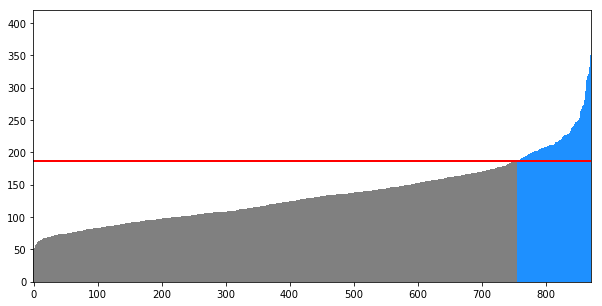

In [283]:
OD_plot_diff_genes_per_cell(outlier_pval_Lgr6_IFE_sel, cutoff_IFE, order = True)

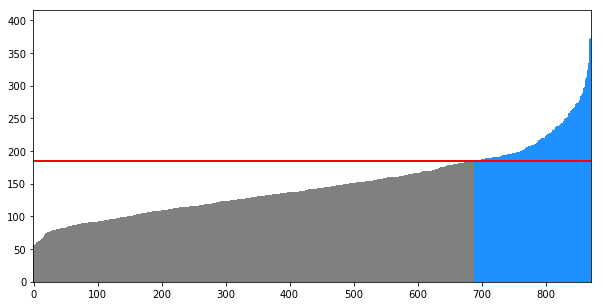

In [284]:
OD_plot_diff_genes_per_cell(outlier_pval_Lgr6_IST_sel, cutoff_IST, order = True)

In [285]:
c_wnd = list(set(c_wnd_IFE) & set(c_wnd_IST))

In [286]:
len(c_wnd)

106

In [287]:
cells_Lgr6_tmp[c_wnd] = 1

In [288]:
Counter(cells_Lgr6_tmp)

Counter({0: 766, 1: 106})

In [289]:
Counter(meta.ix['Days/Sample', c_wnd])

Counter({'1 d - wnd': 33,
         '1 m+ - wnd': 32,
         '10 d - wnd': 9,
         '4 d - wnd': 13,
         '7 d - wnd': 19})

In [290]:
cells_Lgr6_ctrl_all = pd.Series([meta.ix['Days',c] for c in c_wnd if meta.ix['Sample',c] == 'ctrl'],
                                index = [c for c in c_wnd if meta.ix['Sample',c] == 'ctrl'])

In [291]:
Counter(cells_Lgr6_ctrl_all)

Counter()

In [292]:
cells_Lgr6_wnd_all = pd.Series([meta.ix['Days',c] for c in c_wnd if meta.ix['Sample',c] == 'wnd'],
                                index = [c for c in c_wnd if meta.ix['Sample',c] == 'wnd'])

In [293]:
Counter(cells_Lgr6_wnd_all)

Counter({'1 d': 33, '1 m+': 32, '10 d': 9, '4 d': 13, '7 d': 19})

In [294]:
get_enrichment(meta, cells_Lgr6_ctrl_all.index, c_sel_ctrl_area_Lgr6, 
                   cells_Lgr6_wnd_all.index, c_sel_wnd_area_Lgr6)

count - ctrl perc - ctrl count - wnd perc - wnd pval - wnd
1 d             0           0          33       0.22          0
4 d             0           0          13  0.0915493          0
7 d             0           0          19   0.146154          0
10 d            0           0           9   0.062069          0
1 m+            0           0          32   0.410256          0

## Combine wound cells 

In [295]:
cells_Lgr6_wnd = pd.Series()

for c in cells_Lgr6_wnd_all.index:
    cells_Lgr6_wnd[c] = cells_Lgr6_wnd_all[c]

In [296]:
len(cells_Lgr6_wnd)

106

In [297]:
Counter(cells_Lgr6_wnd)

Counter({'1 d': 33, '1 m+': 32, '10 d': 9, '4 d': 13, '7 d': 19})

### Checkpoint

In [298]:
#saveData_v1(cells_Lgr6_wnd, path_output, exp_id, 'cells_Lgr6_wnd')

In [299]:
cells_Lgr6_wnd = loadData_v1(path_output, exp_id, 'cells_Lgr6_wnd', 'Series')

## Add all 0 day control cells to Lgr6 wound cells

In [300]:
cells_Lgr6_wnd_ctrl = cells_Lgr6_wnd.copy()

for c in cells_Lgr6_0d_ctrl.index:
    cells_Lgr6_wnd_ctrl[c] = cells_Lgr6_0d_ctrl[c]

In [301]:
Counter(cells_Lgr6_wnd_ctrl)

Counter({'1 d': 33,
         '1 m+': 32,
         '10 d': 9,
         '4 d': 13,
         '7 d': 19,
         'ctrl - IFE': 130,
         'ctrl - IST': 24})

### Checkpoint

In [302]:
#saveData_v1(cells_Lgr6_wnd_ctrl, path_output, exp_id, 'cells_Lgr6_wnd_ctrl')

In [303]:
cells_Lgr6_wnd_ctrl = loadData_v1(path_output, exp_id, 'cells_Lgr6_wnd_ctrl', 'Series')

## Randomly select 25 IFE 0 day control cells for downstream analysis to ensure that downstream analysis is not dominated by 0 day control (keep all isthmus cells)

In [304]:
c_sel = list(cells_Lgr6_wnd_ctrl[cells_Lgr6_wnd_ctrl!='ctrl - IFE'].index) + list(np.random.choice(cells_Lgr6_wnd_ctrl[cells_Lgr6_wnd_ctrl=='ctrl - IFE'].index, 25, replace = False))

In [305]:
cells_Lgr6_wnd_ctrl_sel = cells_Lgr6_wnd_ctrl[c_sel]

In [306]:
Counter(cells_Lgr6_wnd_ctrl_sel)

Counter({'1 d': 33,
         '1 m+': 32,
         '10 d': 9,
         '4 d': 13,
         '7 d': 19,
         'ctrl - IFE': 25,
         'ctrl - IST': 24})

### Checkpoint

In [307]:
#saveData_v1(cells_Lgr6_wnd_ctrl_sel, path_output, exp_id, 'cells_Lgr6_wnd_ctrl_sel')

In [308]:
cells_Lgr6_wnd_ctrl_sel = loadData_v1(path_output, exp_id, 'cells_Lgr6_wnd_ctrl_sel', 'Series')

# (5) Clustering and tSNE visualization of Lgr6 wound cells

## Feature selection


Dropping unexpressed genes from dataset

After mean expression cutoff of 0.2, 5086 genes remain
Optimization terminated successfully.
         Current function value: 1001.159920
         Iterations: 29
         Function evaluations: 57

After high variance feature selection, 1000 genes remain

Calculating binary logarithm of x + 1


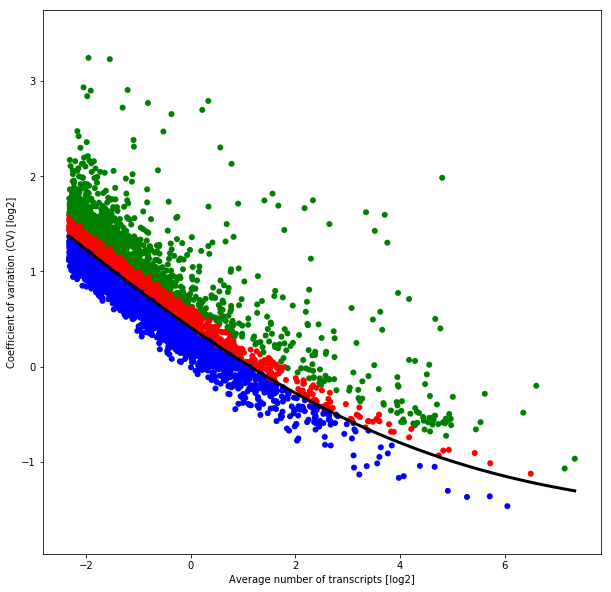

In [309]:
seq_sel_Lgr6_wnd = select_features_v3(seq_sel_Lgr6_norm[cells_Lgr6_wnd_ctrl_sel.index], 0.2, 1000, path_input, return_all=False, drop_spikes = False, drop_markers = False)

### Checkpoint

In [310]:
saveData_v1(seq_sel_Lgr6_wnd, path_output, exp_id, 'seq_sel_Lgr6_wnd')

In [27]:
seq_sel_Lgr6_wnd = loadData_v1(path_output, exp_id, 'seq_sel_Lgr6_wnd', 'DataFrame')

/Users/simjoo/Projects/STRT_wound/scripts/WND_misc_scripts_v2_0.py:240: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  dataset = pd.DataFrame.from_csv('%s/%s_%s.txt' % (path, id_, name), sep = '\t', header = 0, index_col = 0)


## tSNE

In [312]:
seq_sel_Lgr6_wnd_pca, dist_Lgr6_pca = dist_mat_dim_reduc_v2(seq_sel_Lgr6_wnd, dim=5, method='NMF', distance = 'euclidean')

/Users/simjoo/anaconda/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['Liberation Sans'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


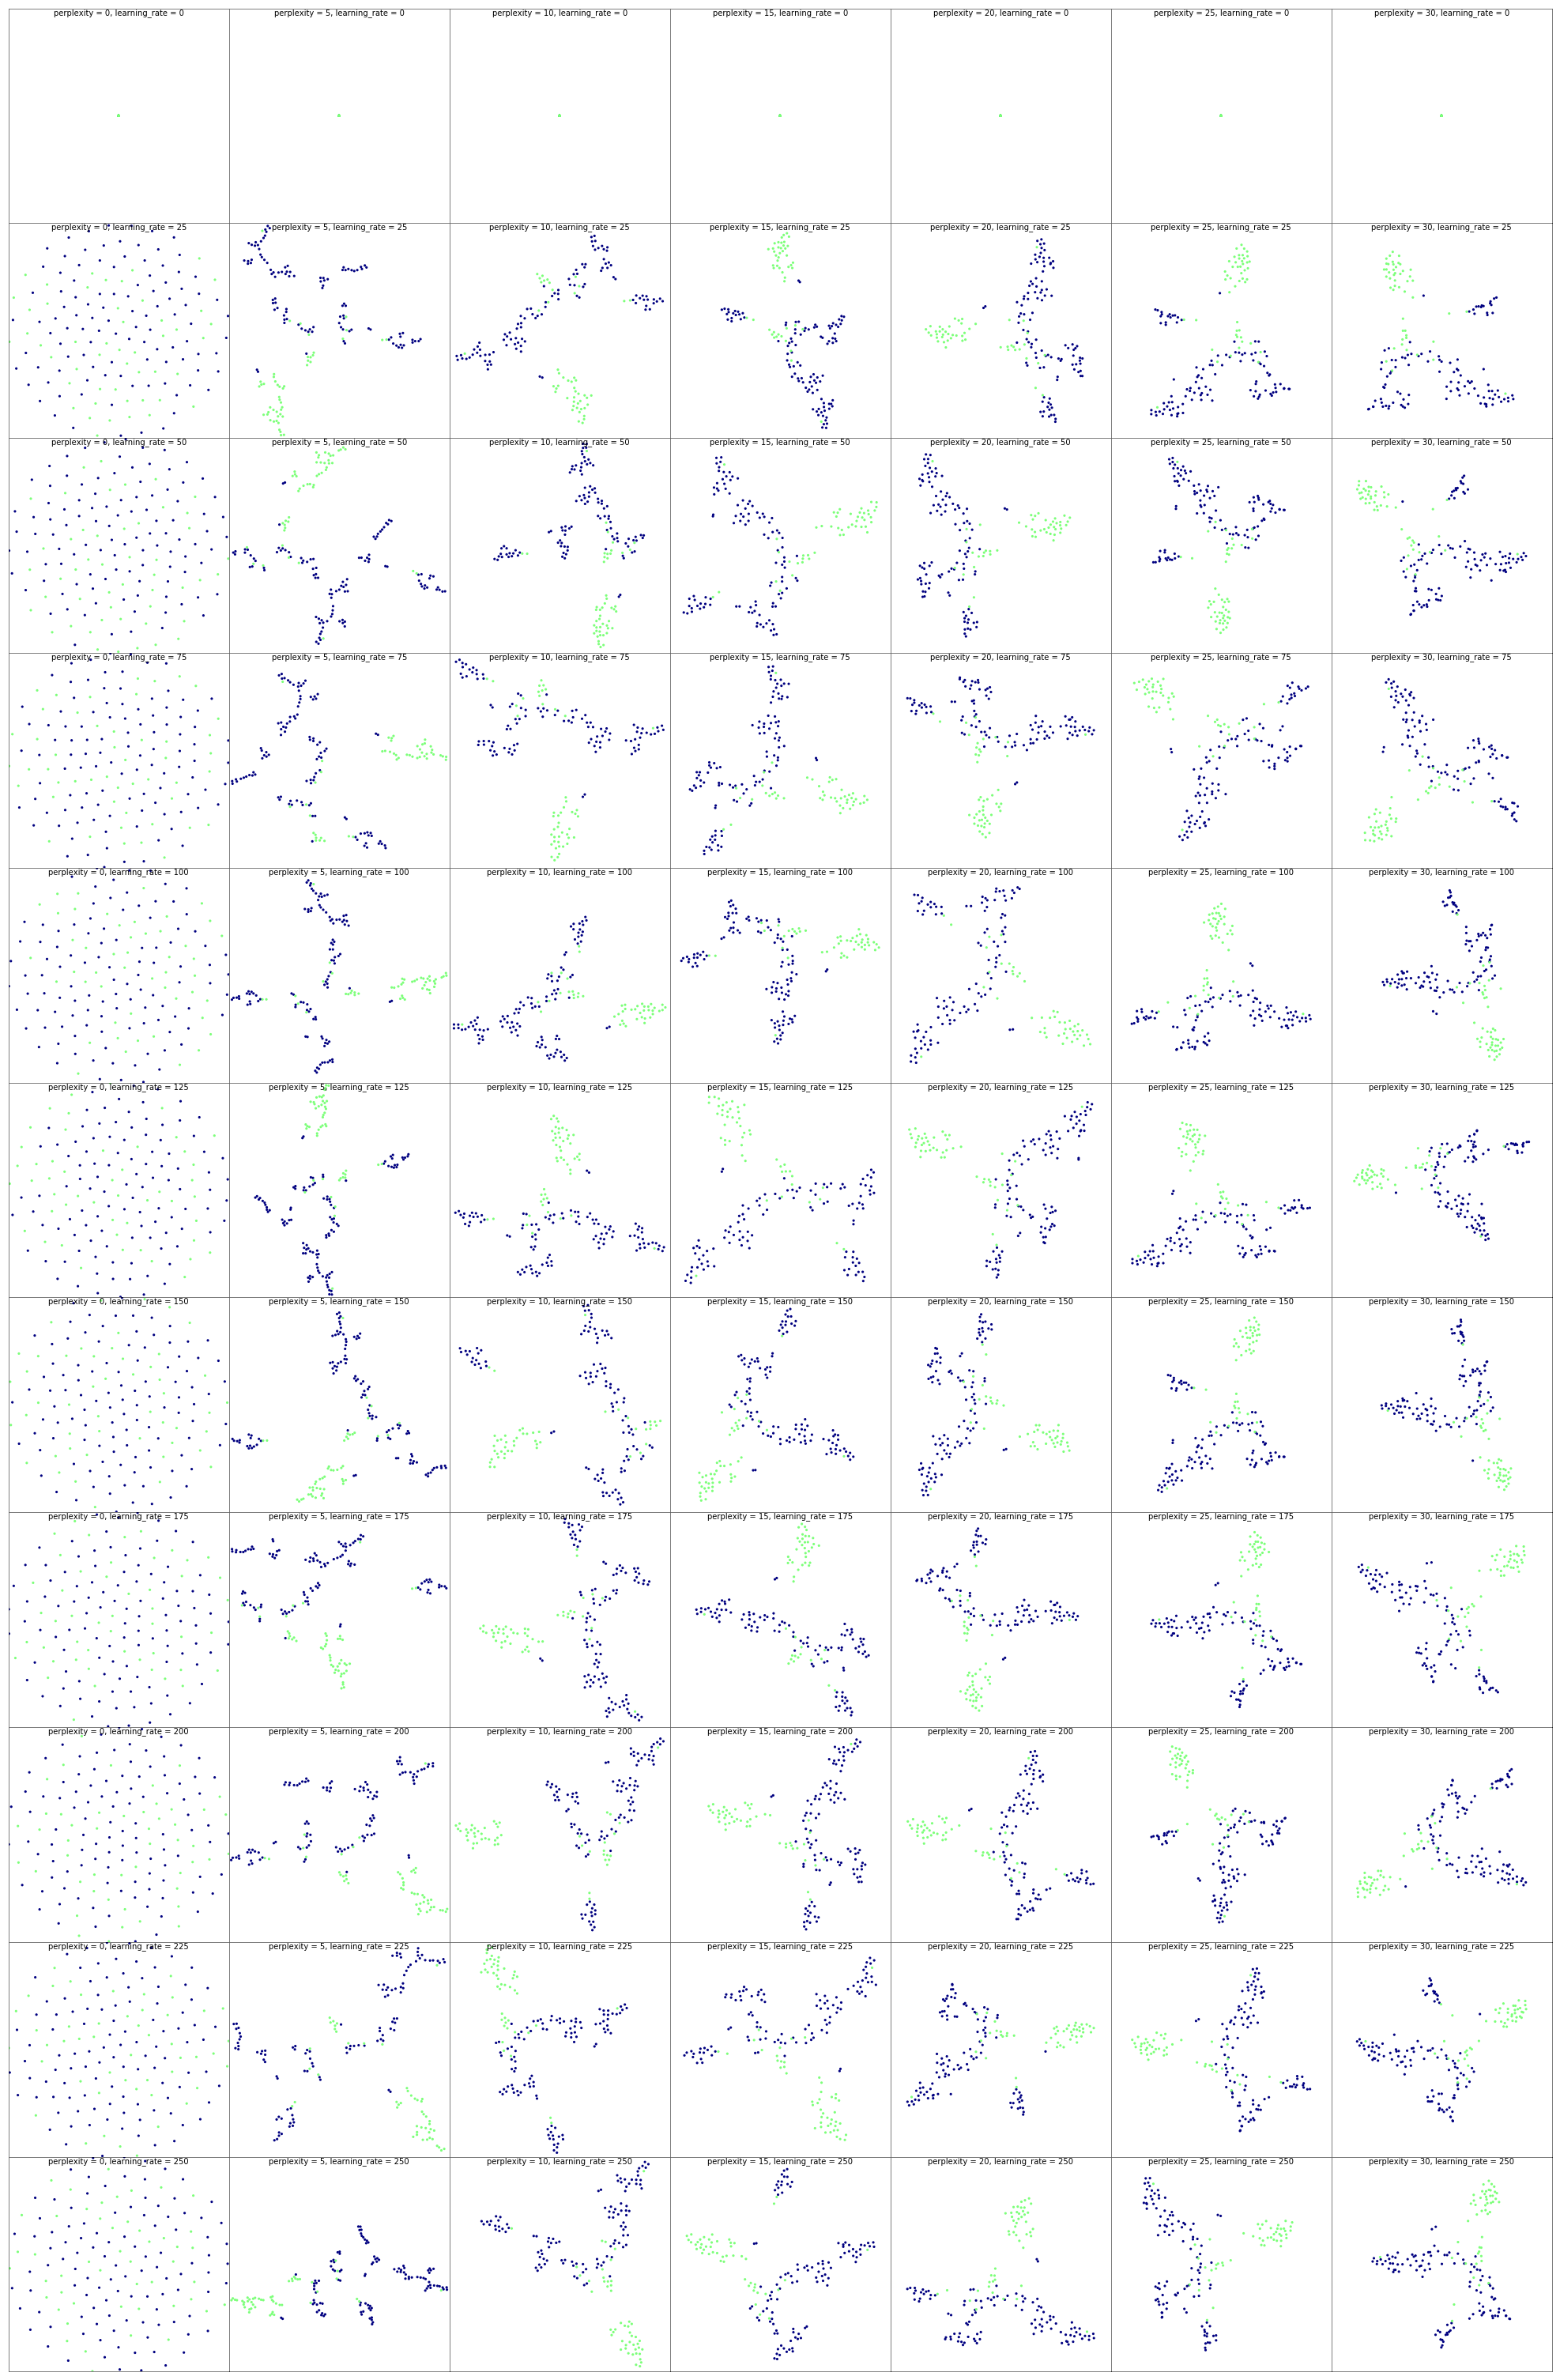

In [313]:
tsne_coords_Lgr6 = tSNE_get_params_v1P(dist_Lgr6_pca, 
                                       cells_Lgr6[cells_Lgr6_wnd_ctrl_sel.index], 
                                       plt.cm.jet,
                                       dview,
                                       np.arange(0,35,5),
                                       2.0,
                                       np.arange(0,275,25),
                                       10000,
                                       sec_var = 'learning_rate')

In [336]:
tsne_Lgr6_wnd_ctrl_sel = tsne_coords_Lgr6[(15,150)]

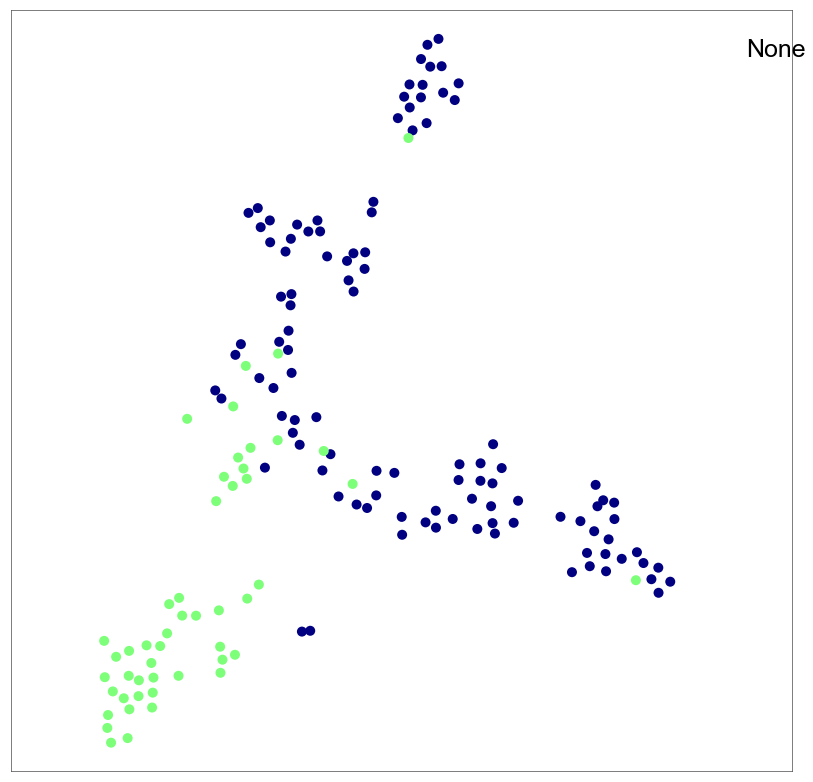

In [337]:
draw_tSNE(tsne_Lgr6_wnd_ctrl_sel, cells_Lgr6[cells_Lgr6_wnd_ctrl_sel.index])

### Checkpoint

In [338]:
#saveData_v1(tsne_Lgr6_wnd_ctrl_sel, path_output, exp_id, 'tsne_Lgr6_wnd_ctrl_sel')

In [339]:
tsne_Lgr6_wnd_ctrl_sel = loadData_v1(path_output, exp_id, 'tsne_Lgr6_wnd_ctrl_sel', 'DataFrame')

## k-means clustering of wound cells

/Users/simjoo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  import sys


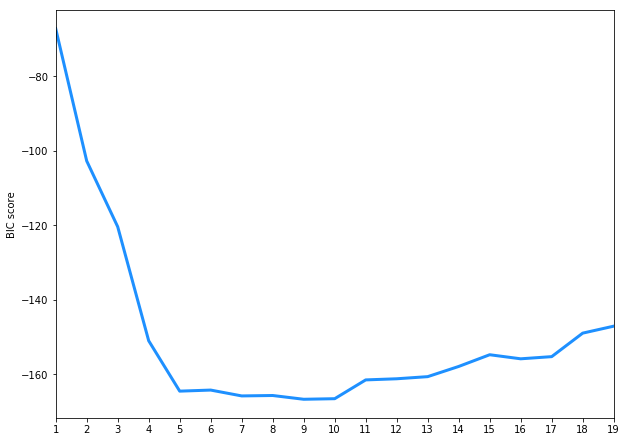

In [340]:
tsne_kmeans_select_n(seq_sel_Lgr6_wnd_pca, 
                     tsne_Lgr6_wnd_ctrl_sel, 
                     cells_Lgr6_wnd.index, 
                     range(1,20), 
                     criterion = 'BIC')

In [476]:
cl_Lgr6_wnd = tsne_kmeans(tsne_Lgr6_wnd_ctrl_sel, cells_Lgr6_wnd.index, 5)

## Manually subdivide WF(hi) cells in WF cluster 1

In [519]:
c_sel = cl_Lgr6_wnd[cl_Lgr6_wnd==1].index

In [521]:
c_sel = seq_sel_Lgr6_norm.ix['Krt6a',c_sel][seq_sel_Lgr6_norm.ix['Krt6a',c_sel]>=25].index

In [522]:
len(c_sel)

5

In [523]:
cl_Lgr6_wnd[c_sel] = 5

In [524]:
cl_Lgr6_wnd = AP_reorder_inclusters(seq_sel_Lgr6_wnd_pca, cl_Lgr6_wnd, 0, linkage='single')

/Users/simjoo/Projects/STRT_wound/scripts/WND_affinity_propagation_v2_0.py:745: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  tmp_Z = sch.linkage(tmp_dist, method = linkage)


## Add 0 day control cells

In [527]:
cl_Lgr6_wnd_ctrl = cl_Lgr6_wnd.copy()

for c in cells_Lgr6_0d_ctrl.index:
    cl_Lgr6_wnd_ctrl[c] = cells_Lgr6_0d_ctrl[c]

## Add randomly selected IFE-like 0 day control cells (and all IST-like 0 day control cells)

In [528]:
cl_Lgr6_wnd_ctrl_sel = cl_Lgr6_wnd.copy()

for c in cells_Lgr6_wnd_ctrl_sel[cells_Lgr6_wnd_ctrl_sel.isin(['ctrl - IFE','ctrl - IST'])].index:
    cl_Lgr6_wnd_ctrl_sel[c] = cells_Lgr6_wnd_ctrl_sel[c]

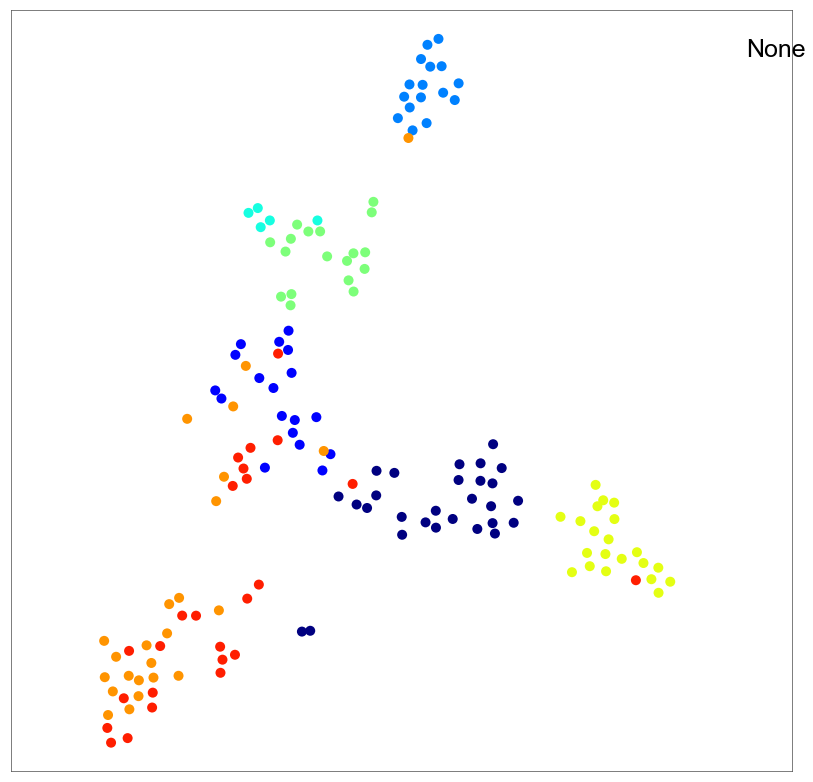

In [529]:
draw_tSNE(tsne_Lgr6_wnd_ctrl_sel, cl_Lgr6_wnd_ctrl_sel)

### Checkpoint

In [531]:
#saveData_v1(cl_Lgr6_wnd, path_output, exp_id, 'cl_Lgr6_wnd')
#saveData_v1(cl_Lgr6_wnd_ctrl, path_output, exp_id, 'cl_Lgr6_wnd_ctrl')
#saveData_v1(cl_Lgr6_wnd_ctrl_sel, path_output, exp_id, 'cl_Lgr6_wnd_ctrl_sel')
#saveData_v1(tsne_Lgr6_wnd_ctrl_sel.ix[cl_Lgr6_wnd_ctrl_sel.index], path_output, exp_id, 'tsne_Lgr6_wnd_ctrl_sel')

In [14]:
cl_Lgr6_wnd = loadData_v1(path_output, exp_id, 'cl_Lgr6_wnd', 'Series')
cl_Lgr6_wnd_ctrl = loadData_v1(path_output, exp_id, 'cl_Lgr6_wnd_ctrl', 'Series')
cl_Lgr6_wnd_ctrl_sel = loadData_v1(path_output, exp_id, 'cl_Lgr6_wnd_ctrl_sel', 'Series')

/Users/simjoo/anaconda/lib/python3.6/site-packages/pandas/core/series.py:2849: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  infer_datetime_format=infer_datetime_format)


# (6) Negative binominal regression of sampling time points

## Define parameters

In [533]:
sf = loadData_v1(path_output, exp_id, 'sf', 'Series')
cells_Lgr5_wnd_ctrl = loadData_v1(path_output, exp_id, 'cells_Lgr5_wnd_ctrl', 'Series')
cells_Lgr6_wnd_ctrl = loadData_v1(path_output, exp_id, 'cells_Lgr6_wnd_ctrl', 'Series')

In [534]:
ix = ['Lgr5 - %s' % gr for gr in return_unique(cells_Lgr5_wnd_ctrl)] + ['Lgr6 - %s' % gr for gr in return_unique(cells_Lgr6_wnd_ctrl)]
col = list(cells_Lgr5_wnd_ctrl.index) + list(cells_Lgr6_wnd_ctrl.index)

NxK = pd.DataFrame(0, index = ix, columns = col)

#bl = seq_[NxK.columns].sum(axis = 0) / seq_[NxK.columns].sum(axis = 0).mean()

for gr in return_unique(cells_Lgr5_wnd_ctrl):
    c_sel = cells_Lgr5_wnd_ctrl[cells_Lgr5_wnd_ctrl==gr].index
    NxK.ix['Lgr5 - %s' % gr, c_sel] = sf[c_sel]
for gr in return_unique(cells_Lgr6_wnd_ctrl):
    c_sel = cells_Lgr6_wnd_ctrl[cells_Lgr6_wnd_ctrl==gr].index
    NxK.ix['Lgr6 - %s' % gr, c_sel] = sf[c_sel]

/Users/simjoo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  # Remove the CWD from sys.path while we load stuff.


In [535]:
NxK.sum(axis=1)

Lgr5 - 7 d            19.983926
Lgr5 - 1 d            64.142643
Lgr5 - 4 d             8.557321
Lgr5 - 10 d           19.396761
Lgr5 - 0 d            67.809849
Lgr6 - 1 m+           40.477562
Lgr6 - 4 d            18.568031
Lgr6 - 7 d            29.974863
Lgr6 - 1 d            58.531520
Lgr6 - 10 d           12.266013
Lgr6 - ctrl - IST     22.087011
Lgr6 - ctrl - IFE    135.869719
dtype: float64

In [536]:
genes_sel_NBR = list(dropNull_v2(seq_sel_norm[NxK.columns], path_input, cutoff_mean = 0.05, drop_markers=False, drop_spikes=False).index)


Dropping unexpressed genes from dataset


In [537]:
len(genes_sel_NBR)

9269

In [538]:
saveData_v1(NxK, path_output, exp_id, 'NxK_time')
saveData_v1(seq_sel.ix[genes_sel_NBR,NxK.columns], path_output, exp_id, 'seq_NBR_time')

## Run model

In [539]:
#define model
    
model = """
    data {
        int<lower=0> N; # number of outcomes
        int<lower=0> K; # number of predictors
        matrix<lower=0>[N,K] x; # predictor matrix
        int y[N]; # outcomes
    }

    parameters {
        vector<lower=1>[K] beta; # coefficients
        real<lower=0.001> r; # overdispersion
    }

    model {
        vector[N] mu;
        vector[N] rv; 
        
        # priors
        r ~ cauchy(0,1);
        beta ~ pareto(1,1.5);

        # vectorize the overdispersion
        for (n in 1:N) {
                rv[n] <- square(r + 1) - 1;
        }

        #regression
        mu <- x * (beta - 1) + 0.001;
        y ~ neg_binomial(mu ./ rv, 1 / rv[1]);
    }
    """

In [540]:
NxK = loadData_v1(path_output, exp_id, 'NxK_time', 'DataFrame')
seq_NBR = loadData_v1(path_output, exp_id, 'seq_NBR_time', 'DataFrame')

In [541]:
"""
NBR_time_traces = neg_binom_regression_free_input_v2P(model, 
                                                    seq_NBR,
                                                    seq_NBR.index,
                                                    len(NxK.columns), 
                                                    len(NxK.index), 
                                                    NxK, 
                                                    path_output, 
                                                    exp_id, 
                                                    'NBR_time_traces',
                                                    5000, 
                                                    dview, 
                                                    iter=275, 
                                                    chains=4, 
                                                    warmup=25,
                                                    n_jobs=4)
"""

"\nNBR_time_traces = neg_binom_regression_free_input_v2P(model, \n                                                    seq_NBR,\n                                                    seq_NBR.index,\n                                                    len(NxK.columns), \n                                                    len(NxK.index), \n                                                    NxK, \n                                                    path_output, \n                                                    exp_id, \n                                                    'NBR_time_traces',\n                                                    5000, \n                                                    dview, \n                                                    iter=275, \n                                                    chains=4, \n                                                    warmup=25,\n                                                    n_jobs=4)\n"

## Checkpoint

In [555]:
NBR_time_traces = loadData_from_pickle_v1(path_output, exp_id, 'NBR_time_traces')

## Get summary

In [556]:
NBR_time_summary = neg_binom_summary_stats_v1P(NBR_time_traces, dview)

## Compare to 0 day control - Lgr5

In [557]:
gr_sel = ['Lgr5 - 0 d','Lgr5 - 1 d', 'Lgr5 - 4 d', 'Lgr5 - 7 d', 'Lgr5 - 10 d']
NBR_time_Lgr5_pval_0d = neg_binom_estimate_prob_v1P(NBR_time_traces[gr_sel], 'Lgr5 - 0 d', dview)

In [559]:
(NBR_time_Lgr5_pval_0d < 0.001).sum(axis = 0)

Lgr5 - 1 d     448
Lgr5 - 4 d      87
Lgr5 - 7 d     175
Lgr5 - 10 d    238
dtype: int64

## Compare to 0 day control - Lgr6

In [561]:
gr_sel = ['Lgr6 - ctrl - IFE','Lgr6 - 1 d', 'Lgr6 - 4 d', 'Lgr6 - 7 d', 'Lgr6 - 10 d', 'Lgr6 - 1 m+']
NBR_time_Lgr6_pval_0d = neg_binom_estimate_prob_v1P(NBR_time_traces[gr_sel], 'Lgr6 - ctrl - IFE', dview)

In [562]:
(NBR_time_Lgr6_pval_0d < 0.001).sum(axis = 0)

Lgr6 - 1 d     802
Lgr6 - 4 d     189
Lgr6 - 7 d     328
Lgr6 - 10 d    141
Lgr6 - 1 m+    311
dtype: int64

### Checkpoint

In [563]:
#saveData_to_pickle_v1(NBR_time_summary, path_output, exp_id, 'NBR_time_summary')
#saveData_to_pickle_v1(NBR_time_Lgr5_pval_0d, path_output, exp_id, 'NBR_time_Lgr5_pval_0d')
#saveData_to_pickle_v1(NBR_time_Lgr6_pval_0d, path_output, exp_id, 'NBR_time_Lgr6_pval_0d')

# (7) Negative binominal regression of wound cell states 

## Without Baseline

## Define parameters

In [542]:
sf = loadData_v1(path_output, exp_id, 'sf', 'Series')
cl_Lgr5_wnd_ctrl = loadData_v1(path_output, exp_id, 'cl_Lgr5_wnd_ctrl', 'Series')
cl_Lgr6_wnd_ctrl = loadData_v1(path_output, exp_id, 'cl_Lgr6_wnd_ctrl', 'Series')

In [543]:
ix = ['Lgr5 - %s' % gr for gr in return_unique(cl_Lgr5_wnd_ctrl)] + ['Lgr6 - %s' % gr for gr in return_unique(cl_Lgr6_wnd_ctrl)]
col = list(cl_Lgr5_wnd_ctrl.index) + list(cl_Lgr6_wnd_ctrl.index)

NxK = pd.DataFrame(0, index = ix, columns = col)

for gr in return_unique(cl_Lgr5_wnd_ctrl):
    c_sel = cl_Lgr5_wnd_ctrl[cl_Lgr5_wnd_ctrl==gr].index
    NxK.ix['Lgr5 - %s' % gr, c_sel] = sf[c_sel]
for gr in return_unique(cl_Lgr6_wnd_ctrl):
    c_sel = cl_Lgr6_wnd_ctrl[cl_Lgr6_wnd_ctrl==gr].index
    NxK.ix['Lgr6 - %s' % gr, c_sel] = sf[c_sel]

/Users/simjoo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


In [544]:
NxK.sum(axis=1)

Lgr5 - 4              23.496348
Lgr5 - 3              17.776614
Lgr5 - 1              21.286703
Lgr5 - 2              37.512939
Lgr5 - 0              12.008046
Lgr5 - ctrl           67.809849
Lgr6 - 2              41.642943
Lgr6 - 4              25.590868
Lgr6 - 3              20.604291
Lgr6 - 5              13.571959
Lgr6 - 1              29.464263
Lgr6 - 0              28.943666
Lgr6 - ctrl - IST     22.087011
Lgr6 - ctrl - IFE    135.869719
dtype: float64

In [550]:
genes_sel_NBR = list(dropNull_v2(seq_sel_norm[NxK.columns], path_input, cutoff_mean = 0.05, drop_markers=False, drop_spikes=False).index)


Dropping unexpressed genes from dataset


In [551]:
len(genes_sel_NBR)

9269

In [552]:
#saveData_v1(NxK, path_output, exp_id, 'NxK_states')
#saveData_v1(seq_sel.ix[genes_sel_NBR, NxK.columns], path_output, exp_id, 'seq_NBR_states')

## Run model

In [553]:
#define model
    
model = """
    data {
        int<lower=0> N; # number of outcomes
        int<lower=0> K; # number of predictors
        matrix<lower=0>[N,K] x; # predictor matrix
        int y[N]; # outcomes
    }

    parameters {
        vector<lower=1>[K] beta; # coefficients
        real<lower=0.001> r; # overdispersion
    }

    model {
        vector[N] mu;
        vector[N] rv; 
        
        # priors
        r ~ cauchy(0,1);
        beta ~ pareto(1,1.5);

        # vectorize the overdispersion
        for (n in 1:N) {
                rv[n] <- square(r + 1) - 1;
        }

        #regression
        mu <- x * (beta - 1) + 0.001;
        y ~ neg_binomial(mu ./ rv, 1 / rv[1]);
    }
    """

In [554]:
NxK = loadData_v1(path_output, exp_id, 'NxK_states', 'DataFrame')
seq_NBR = loadData_v1(path_output, exp_id, 'seq_NBR_states', 'DataFrame')

In [1173]:
"""
NBR_states_traces = neg_binom_regression_free_input_v2P(model, 
                                                    seq_NBR,
                                                    seq_NBR.index,
                                                    len(NxK.columns), 
                                                    len(NxK.index), 
                                                    NxK, 
                                                    path_output, 
                                                    exp_id, 
                                                    'NBR_states_traces',
                                                    2500, 
                                                    dview, 
                                                    iter=275, 
                                                    chains=4, 
                                                    warmup=25,
                                                    n_jobs=4)
"""

"\nNBR_states_traces = neg_binom_regression_free_input_v2P(model, \n                                                    seq_NBR,\n                                                    seq_NBR.index,\n                                                    len(NxK.columns), \n                                                    len(NxK.index), \n                                                    NxK, \n                                                    path_output, \n                                                    exp_id, \n                                                    'NBR_states_traces',\n                                                    5000, \n                                                    dview, \n                                                    iter=275, \n                                                    chains=4, \n                                                    warmup=25,\n                                                    n_jobs=4)\n"

### Checkpoint

In [1121]:
NBR_states_traces = loadData_from_pickle_v1(path_output, exp_id, 'NBR_states_traces')

## Get summary

In [1122]:
NBR_states_summary = neg_binom_summary_stats_v1P(NBR_states_traces, dview)

## Compare to 0 day control - Lgr5

In [1124]:
gr_sel = ['Lgr5 - 4', 'Lgr5 - 3', 'Lgr5 - 1', 'Lgr5 - 2', 'Lgr5 - 0', 'Lgr5 - ctrl']
NBR_states_Lgr5_pval_0d = neg_binom_estimate_prob_v1P(NBR_states_traces[gr_sel], 'Lgr5 - ctrl', dview)

In [1125]:
(NBR_states_Lgr5_pval_0d < 0.001).sum(axis = 0)

Lgr5 - 4    322
Lgr5 - 3     85
Lgr5 - 1    122
Lgr5 - 2    411
Lgr5 - 0    307
dtype: int64

## Compare to 0 day control - Lgr6

In [1126]:
gr_sel = ['Lgr6 - 5', 'Lgr6 - 3', 'Lgr6 - 0', 'Lgr6 - 2', 'Lgr6 - 1','Lgr6 - 4','Lgr6 - ctrl - IST', 'Lgr6 - ctrl - IFE']
NBR_states_Lgr6_pval_0d = neg_binom_estimate_prob_v1P(NBR_states_traces[gr_sel], 'Lgr6 - ctrl - IFE', dview)

In [1127]:
(NBR_states_Lgr6_pval_0d < 0.001).sum(axis = 0)

Lgr6 - 5             354
Lgr6 - 3             234
Lgr6 - 0             406
Lgr6 - 2             389
Lgr6 - 1             537
Lgr6 - 4             224
Lgr6 - ctrl - IST     37
dtype: int64

## Compare to 0 day control - Lgr6 vs Lgr5

In [1128]:
gr_sel = ['Lgr5 - ctrl','Lgr6 - ctrl - IFE']
NBR_states_Lgr6_pval_Lgr5_0d = neg_binom_estimate_prob_v1P(NBR_states_traces[gr_sel], 'Lgr5 - ctrl', dview)

In [1129]:
(NBR_states_Lgr6_pval_Lgr5_0d < 0.001).sum(axis = 0)

Lgr6 - ctrl - IFE    895
dtype: int64

In [1130]:
gr_sel = ['Lgr5 - ctrl','Lgr6 - ctrl - IFE']
NBR_states_Lgr5_pval_Lgr6_0d = neg_binom_estimate_prob_v1P(NBR_states_traces[gr_sel], 'Lgr6 - ctrl - IFE', dview)

In [1131]:
(NBR_states_Lgr5_pval_Lgr6_0d < 0.001).sum(axis = 0)

Lgr5 - ctrl    340
dtype: int64

### Checkpoint

In [1132]:
#saveData_to_pickle_v1(NBR_states_summary, path_output, exp_id, 'NBR_states_summary')
#saveData_to_pickle_v1(NBR_states_Lgr5_pval_0d, path_output, exp_id, 'NBR_states_Lgr5_pval_0d')
#saveData_to_pickle_v1(NBR_states_Lgr6_pval_0d, path_output, exp_id, 'NBR_states_Lgr6_pval_0d')
#saveData_to_pickle_v1(NBR_states_Lgr5_pval_Lgr6_0d, path_output, exp_id, 'NBR_states_Lgr5_pval_Lgr6_0d')
#saveData_to_pickle_v1(NBR_states_Lgr6_pval_Lgr5_0d, path_output, exp_id, 'NBR_states_Lgr6_pval_Lgr5_0d')

In [1094]:
NBR_states_Lgr5_pval_0d = loadData_from_pickle_v1(path_output, exp_id, 'NBR_states_Lgr5_pval_0d')
NBR_states_Lgr6_pval_0d = loadData_from_pickle_v1(path_output, exp_id, 'NBR_states_Lgr6_pval_0d')

## With Baseline

## Define parameters

In [25]:
seq_sel = loadData_v1(path_output, exp_id, 'seq_sel', 'DataFrame')
seq_sel_norm = loadData_v1(path_output, exp_id, 'seq_sel_norm', 'DataFrame')

In [21]:
sf = loadData_v1(path_output, exp_id, 'sf', 'Series')
cl_Lgr5_wnd_ctrl = loadData_v1(path_output, exp_id, 'cl_Lgr5_wnd_ctrl', 'Series')
cl_Lgr6_wnd_ctrl = loadData_v1(path_output, exp_id, 'cl_Lgr6_wnd_ctrl', 'Series')

In [16]:
ix = ['Lgr5 - %s' % gr for gr in return_unique(cl_Lgr5_wnd_ctrl)] + ['Lgr6 - %s' % gr for gr in return_unique(cl_Lgr6_wnd_ctrl)] + ['Baseline']
col = list(cl_Lgr5_wnd_ctrl.index) + list(cl_Lgr6_wnd_ctrl.index)

NxK = pd.DataFrame(0, index = ix, columns = col)

NxK.ix['Baseline'] = sf[NxK.columns]

for gr in return_unique(cl_Lgr5_wnd_ctrl):
    c_sel = cl_Lgr5_wnd_ctrl[cl_Lgr5_wnd_ctrl==gr].index
    NxK.ix['Lgr5 - %s' % gr, c_sel] = sf[c_sel]
for gr in return_unique(cl_Lgr6_wnd_ctrl):
    c_sel = cl_Lgr6_wnd_ctrl[cl_Lgr6_wnd_ctrl==gr].index
    NxK.ix['Lgr6 - %s' % gr, c_sel] = sf[c_sel]

/Users/simjoo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  


In [17]:
NxK.sum(axis=1)

Lgr5 - 1              28.915593
Lgr5 - 4              25.835876
Lgr5 - 5              12.962329
Lgr5 - 0              20.662263
Lgr5 - 3              18.073480
Lgr5 - 2              17.540019
Lgr5 - ctrl           67.809849
Lgr6 - 3              41.981051
Lgr6 - 5              30.191149
Lgr6 - 4               9.302023
Lgr6 - 2              31.316989
Lgr6 - 0              24.916235
Lgr6 - 1              27.463018
Lgr6 - ctrl - IST     18.779606
Lgr6 - ctrl - IFE    139.177125
Baseline             514.926604
dtype: float64

In [22]:
genes_sel_NBR = list(dropNull_v2(seq_sel_norm[NxK.columns], path_input, cutoff_mean = 0.05, drop_markers=False, drop_spikes=False).index)


Dropping unexpressed genes from dataset


In [23]:
len(genes_sel_NBR)

9278

In [26]:
saveData_v1(NxK, path_output, exp_id, 'NxK_states_bl')
saveData_v1(seq_sel.ix[genes_sel_NBR], path_output, exp_id, 'seq_NBR_states_bl')

/Users/simjoo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  


## Run model

In [27]:
#define model
    
model = """
    data {
        int<lower=0> N; # number of outcomes
        int<lower=0> K; # number of predictors
        matrix<lower=0>[N,K] x; # predictor matrix
        int y[N]; # outcomes
    }

    parameters {
        vector<lower=1>[K] beta; # coefficients
        real<lower=0.001> r; # overdispersion
    }

    model {
        vector[N] mu;
        vector[N] rv; 
        
        # priors
        r ~ cauchy(0,1);
        beta ~ pareto(1,1.5);

        # vectorize the overdispersion
        for (n in 1:N) {
                rv[n] <- square(r + 1) - 1;
        }

        #regression
        mu <- x * (beta - 1) + 0.001;
        y ~ neg_binomial(mu ./ rv, 1 / rv[1]);
    }
    """

In [28]:
NxK = loadData_v1(path_output, exp_id, 'NxK_states_bl', 'DataFrame')
seq_NBR = loadData_v1(path_output, exp_id, 'seq_NBR_states_bl', 'DataFrame')

In [30]:
"""
NBR_states_bl_traces = neg_binom_regression_free_input_v2P(model, 
                                                    seq_NBR,
                                                    seq_NBR.index,
                                                    len(NxK.columns), 
                                                    len(NxK.index), 
                                                    NxK, 
                                                    path_output, 
                                                    exp_id, 
                                                    'NBR_states_bl_traces',
                                                    5000, 
                                                    dview, 
                                                    iter=275, 
                                                    chains=4, 
                                                    warmup=25,
                                                    n_jobs=4)
"""

"\nNBR_states_bl_traces = neg_binom_regression_free_input_v2P(model, \n                                                    seq_NBR,\n                                                    seq_NBR.index,\n                                                    len(NxK.columns), \n                                                    len(NxK.index), \n                                                    NxK, \n                                                    path_output, \n                                                    exp_id, \n                                                    'NBR_states_bl_traces',\n                                                    5000, \n                                                    dview, \n                                                    iter=275, \n                                                    chains=4, \n                                                    warmup=25,\n                                                    n_jobs=4)\n"

# (8) Analysis of Lgr5 wound cells based on genes overexpressed in outer bulge vs. IFE cells during telogen

## Fuse and normalize datasets

In [564]:
seq_sel = loadData_v1(path_output, exp_id, 'seq_sel', 'DataFrame')

In [565]:
cl_Lgr5_wnd_ctrl = loadData_v1(path_output, exp_id, 'cl_Lgr5_wnd_ctrl', 'Series')
cl_Lgr5_wnd_ctrl_sel = loadData_v1(path_output, exp_id, 'cl_Lgr5_wnd_ctrl_sel', 'Series')

cl_Lgr6_wnd_ctrl = loadData_v1(path_output, exp_id, 'cl_Lgr6_wnd_ctrl', 'Series')
cl_Lgr6_wnd_ctrl_sel = loadData_v1(path_output, exp_id, 'cl_Lgr6_wnd_ctrl_sel', 'Series')

In [566]:
seq_epi = loadData_v1(path_input, '201509151726', 'seq', 'DataFrame')
cl_epi_1st = loadData_v1(path_input, '201509151726', 's_groups_1st', 'Series')

In [567]:
genes_comb = [g for g in seq_sel.index if g in seq_epi.index]

In [568]:
len(genes_comb)

21917

In [569]:
c_sel_IFE_OB = cl_epi_1st[cl_epi_1st.isin([2,7])].index

In [570]:
len(c_sel_IFE_OB)

541

In [571]:
c_sel_wnd = list(cl_Lgr5_wnd_ctrl.index) + list(cl_Lgr6_wnd_ctrl.index)

In [572]:
len(c_sel_wnd)

462

In [573]:
seq_wnd_IFE_OB = pd.concat([seq_sel.ix[genes_comb, c_sel_wnd], seq_epi.ix[genes_comb,c_sel_IFE_OB]], axis = 1)

/Users/simjoo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.



Dropping unexpressed genes from dataset

After mean expression cutoff of 0.5, 1879 genes remain
Optimization terminated successfully.
         Current function value: 378.041696
         Iterations: 24
         Function evaluations: 47

After high variance feature selection, 0 genes remain

Calculating binary logarithm of x + 1


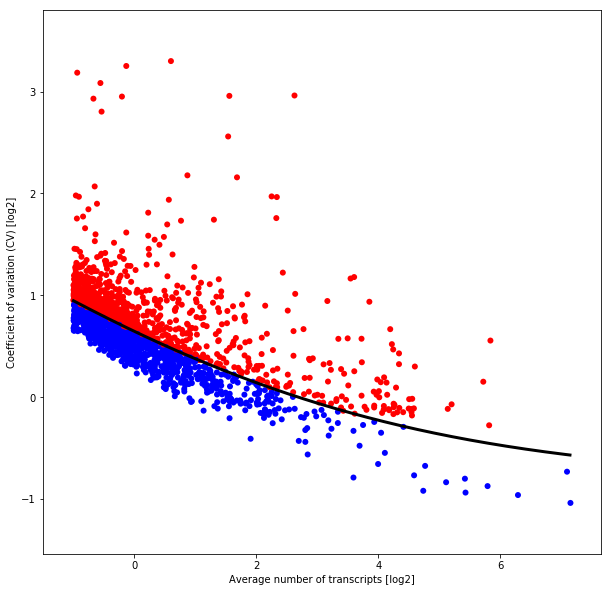

In [574]:
genes_sel_diff = select_features_v3(seq_wnd_IFE_OB, 0.5, -2000, path_input, return_all=True, drop_spikes = False, drop_markers = False)[1]

In [575]:
genes_sel = genes_sel_diff[genes_sel_diff<0].index

In [576]:
len(genes_sel)

949

In [577]:
sf_wnd_IFE_OB = get_size_factors(seq_wnd_IFE_OB.ix[genes_sel])

In [578]:
seq_wnd_IFE_OB_norm = seq_wnd_IFE_OB / sf_wnd_IFE_OB

### Checkpoint

In [579]:
saveData_v1(sf_wnd_IFE_OB, path_output, exp_id, 'sf_wnd_IFE_OB')
saveData_v1(seq_wnd_IFE_OB_norm, path_output, exp_id, 'seq_wnd_IFE_OB_norm')

In [967]:
seq_wnd_IFE_OB_norm = loadData_v1(path_output, exp_id, 'seq_wnd_IFE_OB_norm', 'DataFrame')

## Feature selection

In [581]:
NBR_1st_traces = loadData_from_pickle_v1(path_input, '201509151726', 'NBR_1st_traces')

In [841]:
NBR_1st_telogen_IFEB_vs_OB = neg_binom_estimate_prob_all_groups_v1P(NBR_1st_traces[['7','2']], dview)

In [842]:
genes_sel_OB = NBR_1st_telogen_IFEB_vs_OB['7'][NBR_1st_telogen_IFEB_vs_OB['7']==0].index
genes_sel_IFEB = NBR_1st_telogen_IFEB_vs_OB['2'][NBR_1st_telogen_IFEB_vs_OB['2']==0].index

In [843]:
len(genes_sel_OB), len(genes_sel_IFEB)

(310, 311)

In [844]:
genes_sel_IFE_OB = list(genes_sel_OB) + list(genes_sel_IFEB)

In [845]:
len(genes_sel_IFE_OB)

621

In [915]:
genes_sel_IFE_OB = list(np.random.choice(genes_sel_OB, 250, replace = False)) + list(np.random.choice(genes_sel_IFEB, 250, replace = False))

In [916]:
len(genes_sel_IFE_OB)

500

## Combine OB and IFEB data with Lgr5 ctrl and wnd cells, Lgr6 WF cells and 25 randomly selected basal Lgr6 control cells

In [917]:
cl_wnd_OB_IFE = pd.Series()

for c in cl_Lgr5_wnd_ctrl_sel.index:
    cl_wnd_OB_IFE[c] = 'Lgr5 - %s' % cl_Lgr5_wnd_ctrl_sel[c]
for c in cl_Lgr6_wnd_ctrl_sel[cl_Lgr6_wnd_ctrl_sel.isin(['5','1'])].index:
    cl_wnd_OB_IFE[c] = 'Lgr6 - %s' % cl_Lgr6_wnd_ctrl_sel[c]                         
for c in np.random.choice(cl_epi_1st[cl_epi_1st==2].index, 25, replace = False):
    cl_wnd_OB_IFE[c] = 'IFEB'
for c in np.random.choice(cl_epi_1st[cl_epi_1st==7].index, 25, replace = False):
    cl_wnd_OB_IFE[c] = 'OB'

In [918]:
Counter(cl_wnd_OB_IFE)

Counter({'IFEB': 25,
         'Lgr5 - 0': 11,
         'Lgr5 - 1': 22,
         'Lgr5 - 2': 32,
         'Lgr5 - 3': 19,
         'Lgr5 - 4': 22,
         'Lgr5 - ctrl': 25,
         'Lgr6 - 1': 18,
         'Lgr6 - 5': 5,
         'OB': 25})

### Checkpoint

In [919]:
#saveData_v1(cl_wnd_OB_IFE, path_output, exp_id, 'cl_wnd_OB_IFE')

In [920]:
cl_wnd_OB_IFE = loadData_v1(path_output, exp_id, 'cl_wnd_OB_IFE', 'Series')

## tSNE

In [995]:
seq_wnd_IFE_OB_norm_OB = dist_mat_dim_reduc_v2(log2Transform(seq_wnd_IFE_OB_norm.ix[genes_sel_OB, cl_wnd_OB_IFE.index]), dim=20, method='PCA', distance = 'euclidean')[0]
seq_wnd_IFE_OB_norm_IFE = dist_mat_dim_reduc_v2(log2Transform(seq_wnd_IFE_OB_norm.ix[genes_sel_IFEB, cl_wnd_OB_IFE.index]), dim=20, method='PCA', distance = 'euclidean')[0]


Calculating binary logarithm of x + 1

Calculating binary logarithm of x + 1


In [996]:
seq_wnd_IFE_OB_norm_pca = pd.concat([seq_wnd_IFE_OB_norm_OB, seq_wnd_IFE_OB_norm_IFE], axis = 0)

In [997]:
dist_tsne_wnd_IFE_OB = pd.DataFrame(squareform(pdist(np.array(seq_wnd_IFE_OB_norm_pca.T), 'euclidean')), index = seq_wnd_IFE_OB_norm_pca.columns, columns = seq_wnd_IFE_OB_norm_pca.columns)

/Users/simjoo/anaconda/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['Liberation Sans'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


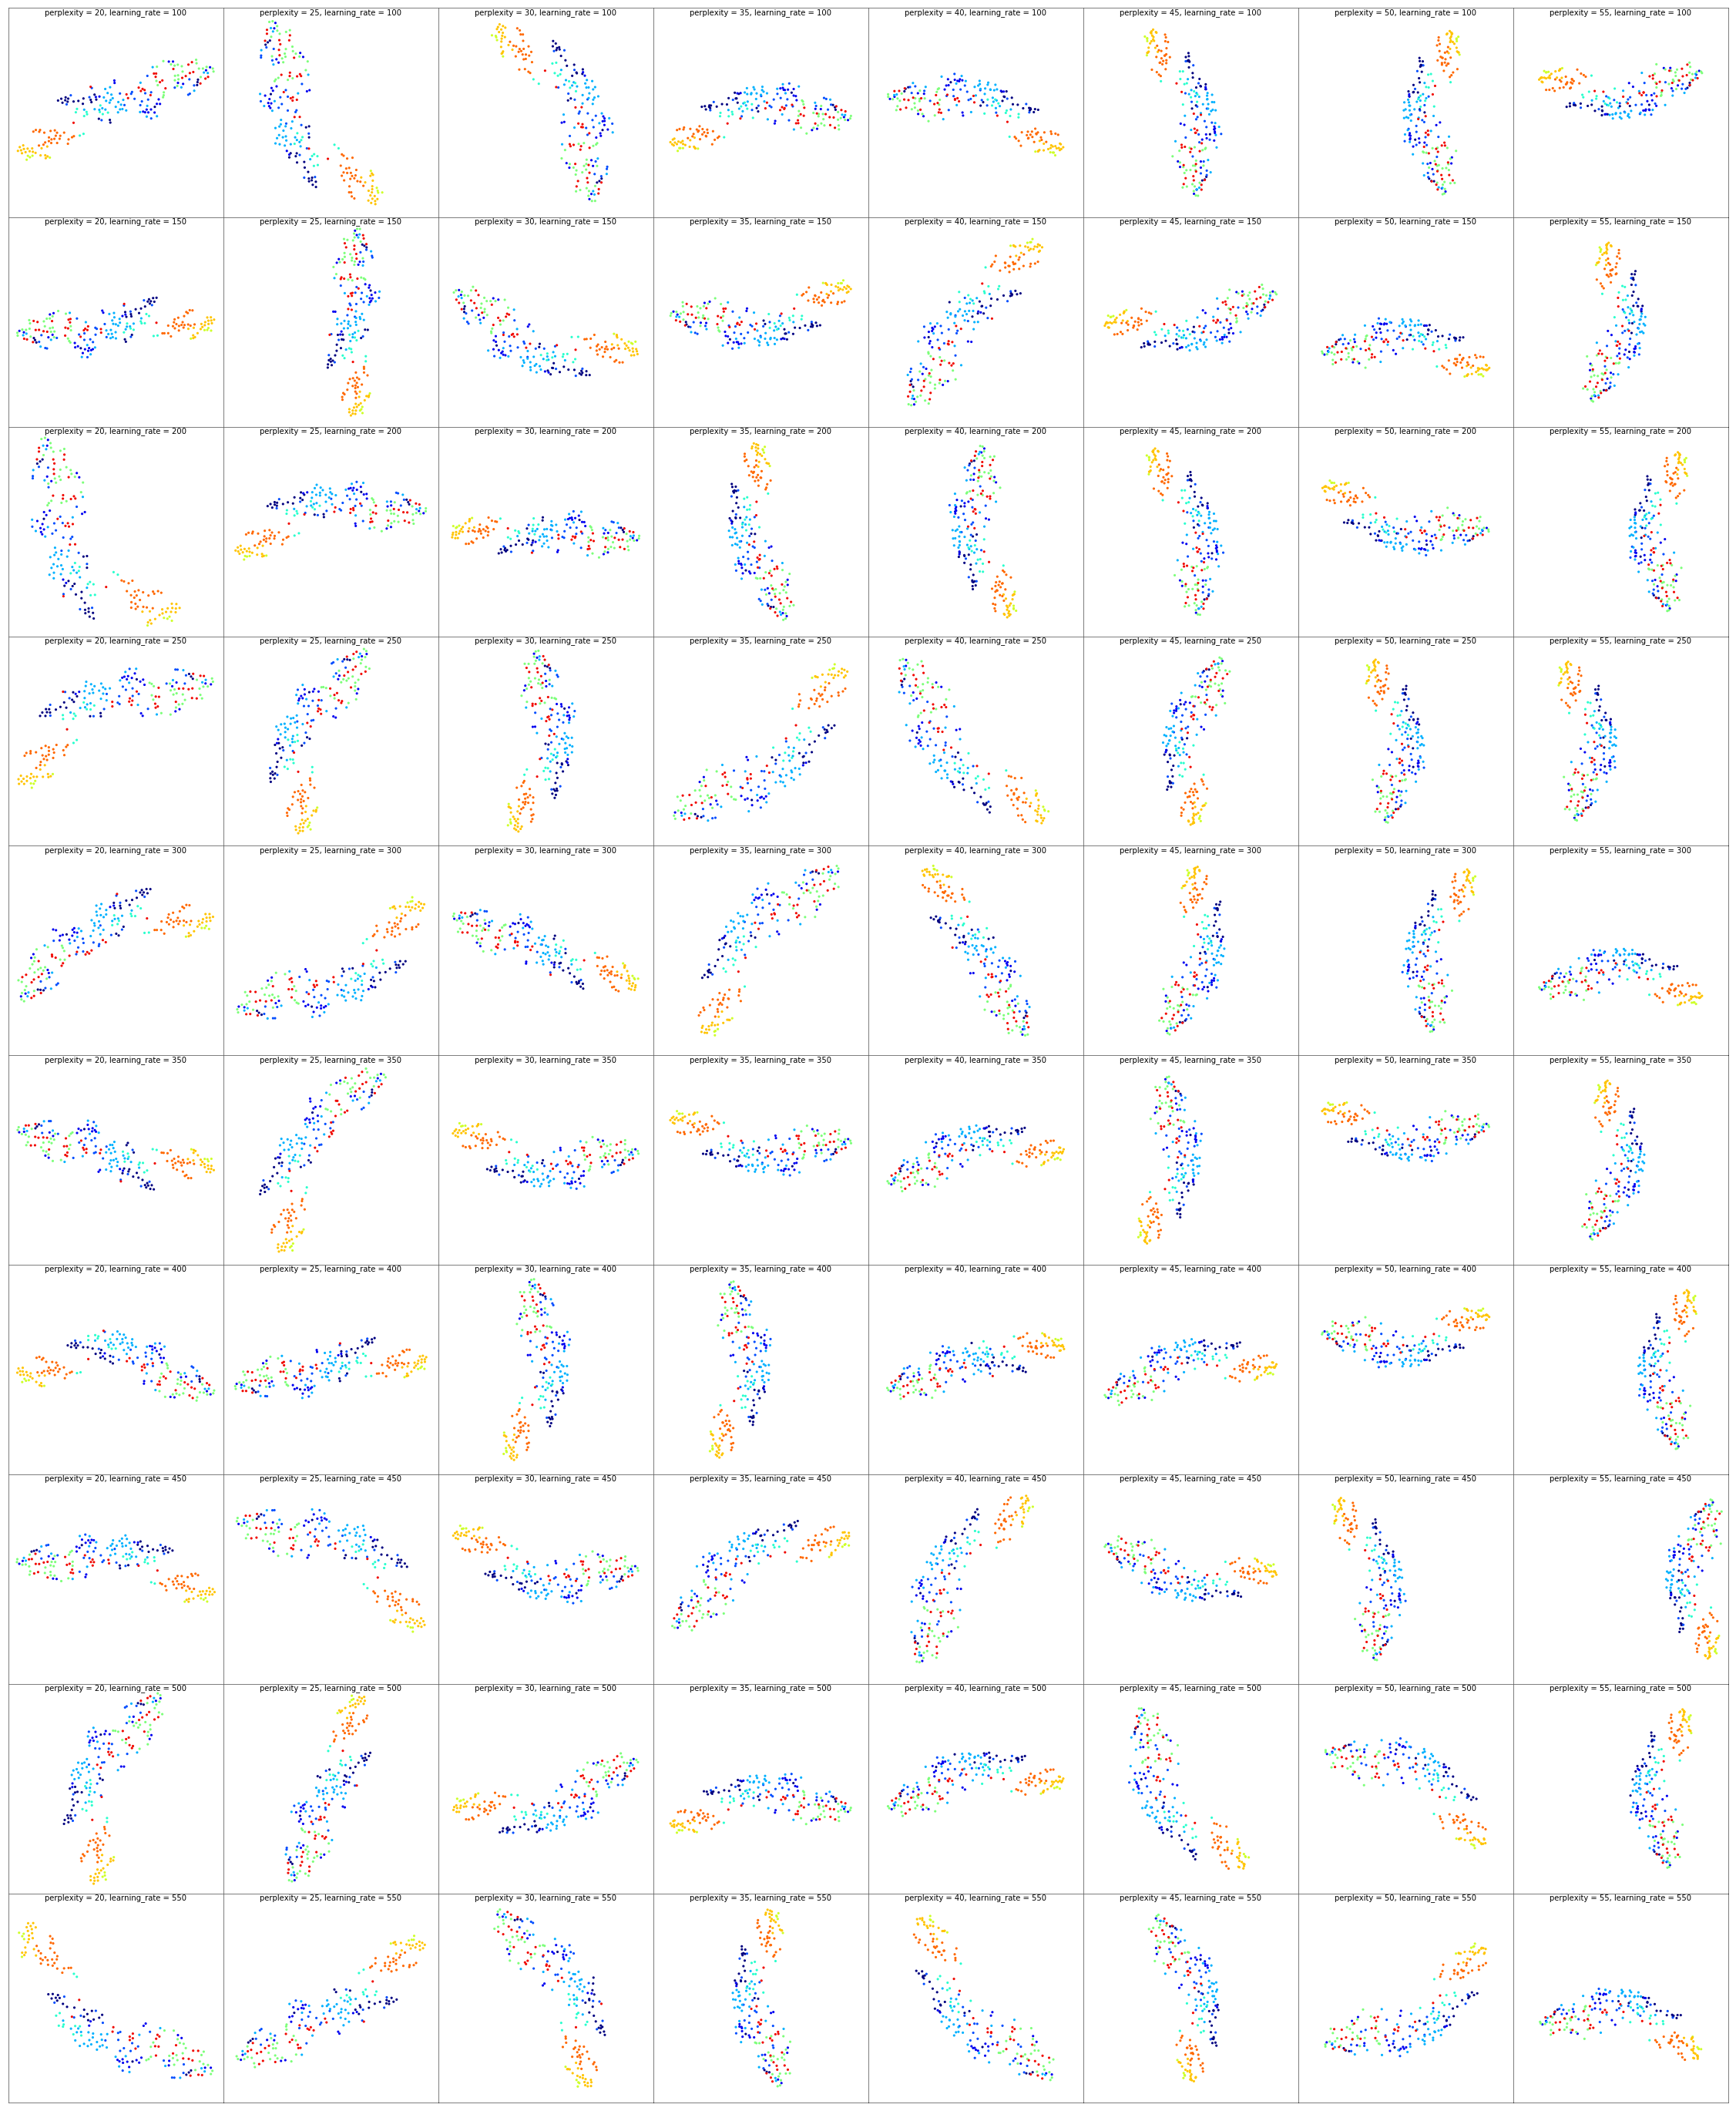

In [998]:
tsne_coords_wnd_IFE_OB = tSNE_get_params_v1P(dist_tsne_wnd_IFE_OB, 
                                         cl_wnd_OB_IFE,
                                         plt.cm.jet,
                                         dview,
                                         np.arange(20,60,5), 
                                         2.0, 
                                         np.arange(100,600,50), 
                                         10000, 
                                         sec_var = 'learning_rate')

In [1046]:
tsne_wnd_IFE_OB = tsne_coords_wnd_IFE_OB[(40,450)]

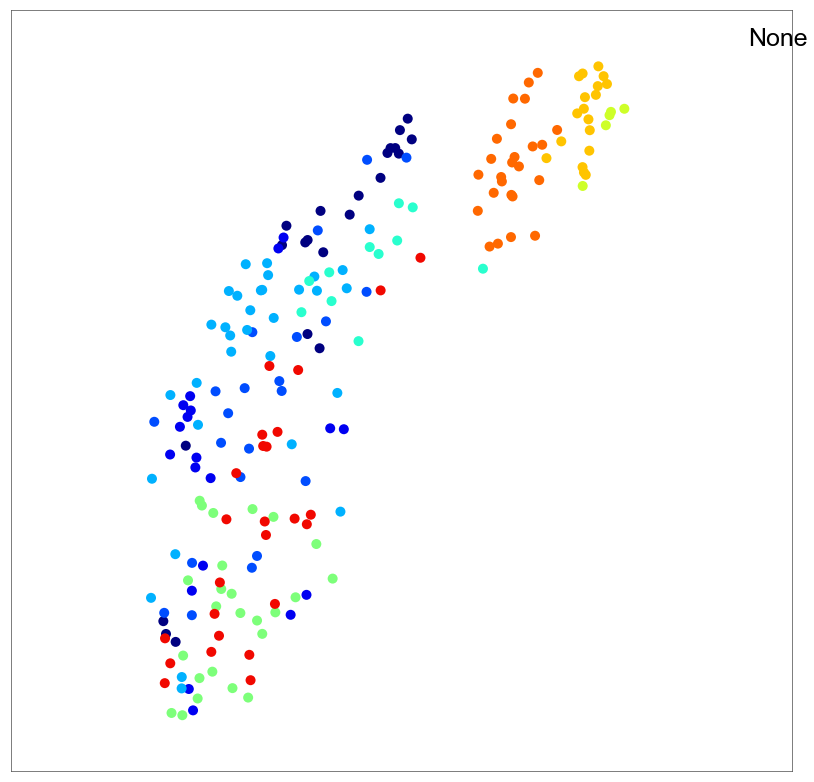

In [1047]:
draw_tSNE(tsne_wnd_IFE_OB, cl_wnd_OB_IFE)

### Checkpoint

In [1048]:
#saveData_v1(tsne_wnd_IFE_OB, path_output, exp_id, 'tsne_wnd_IFE_OB')

In [1049]:
tsne_wnd_IFE_OB = loadData_v1(path_output, exp_id, 'tsne_wnd_IFE_OB', 'DataFrame')

## Pseudotemporal ordering (exluding telogen and Lgr6 cells)

In [1050]:
dist_mat_tsne_Lgr5_OB_IFE = pairwise_distance_2d(tsne_wnd_IFE_OB.ix[cl_Lgr5_wnd_ctrl_sel.index])

/Users/simjoo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.



Creating MST

Diameter path between 1772117065-F01 and 1772117073-C03 with lenght 60

Creating PQ-Tree

Finding permutations

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53

Returning coordinates



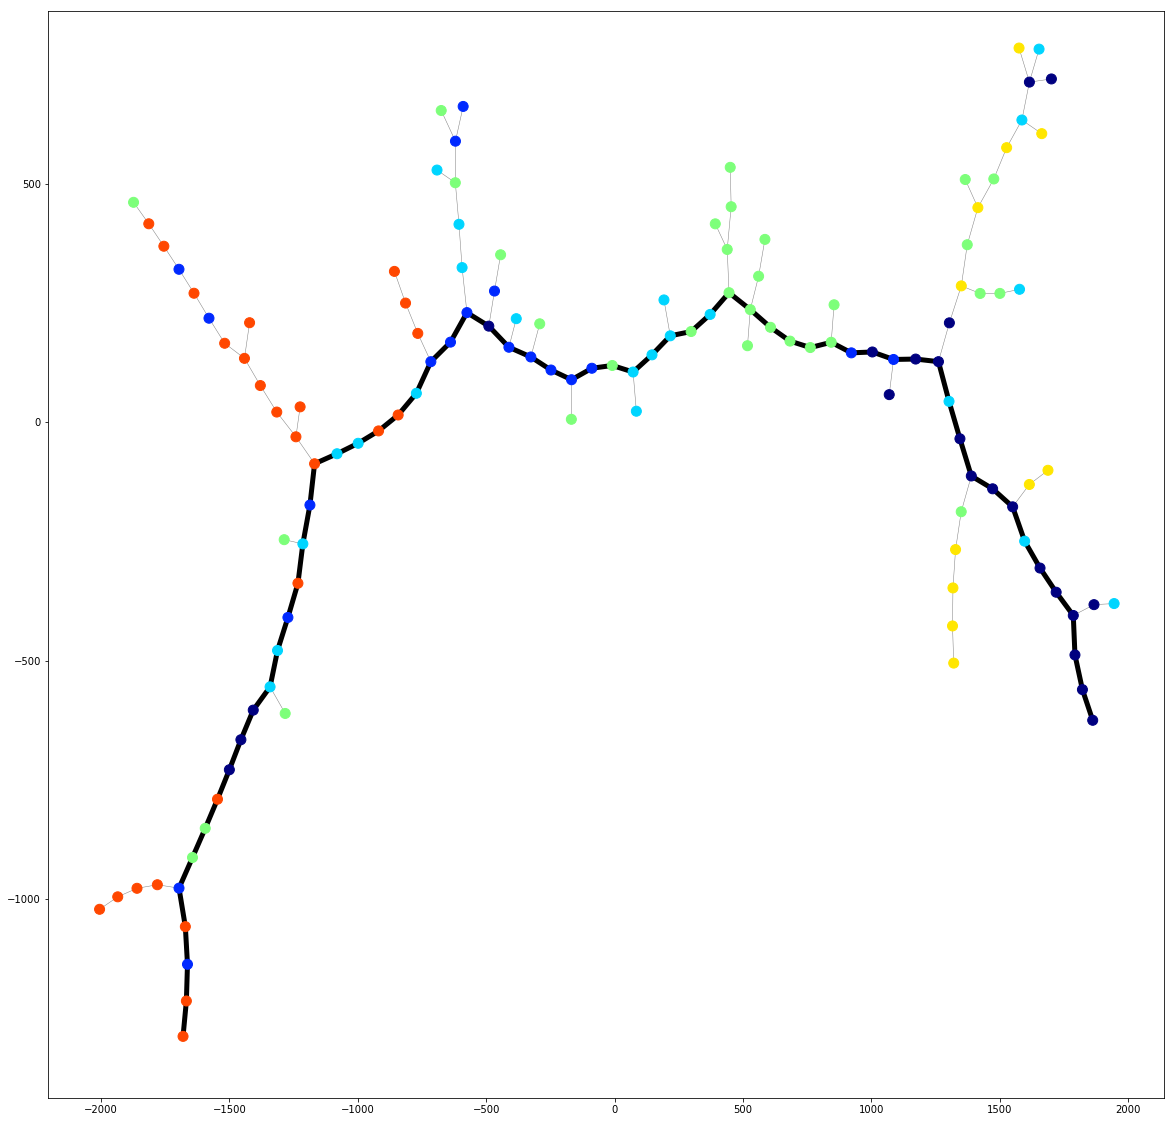

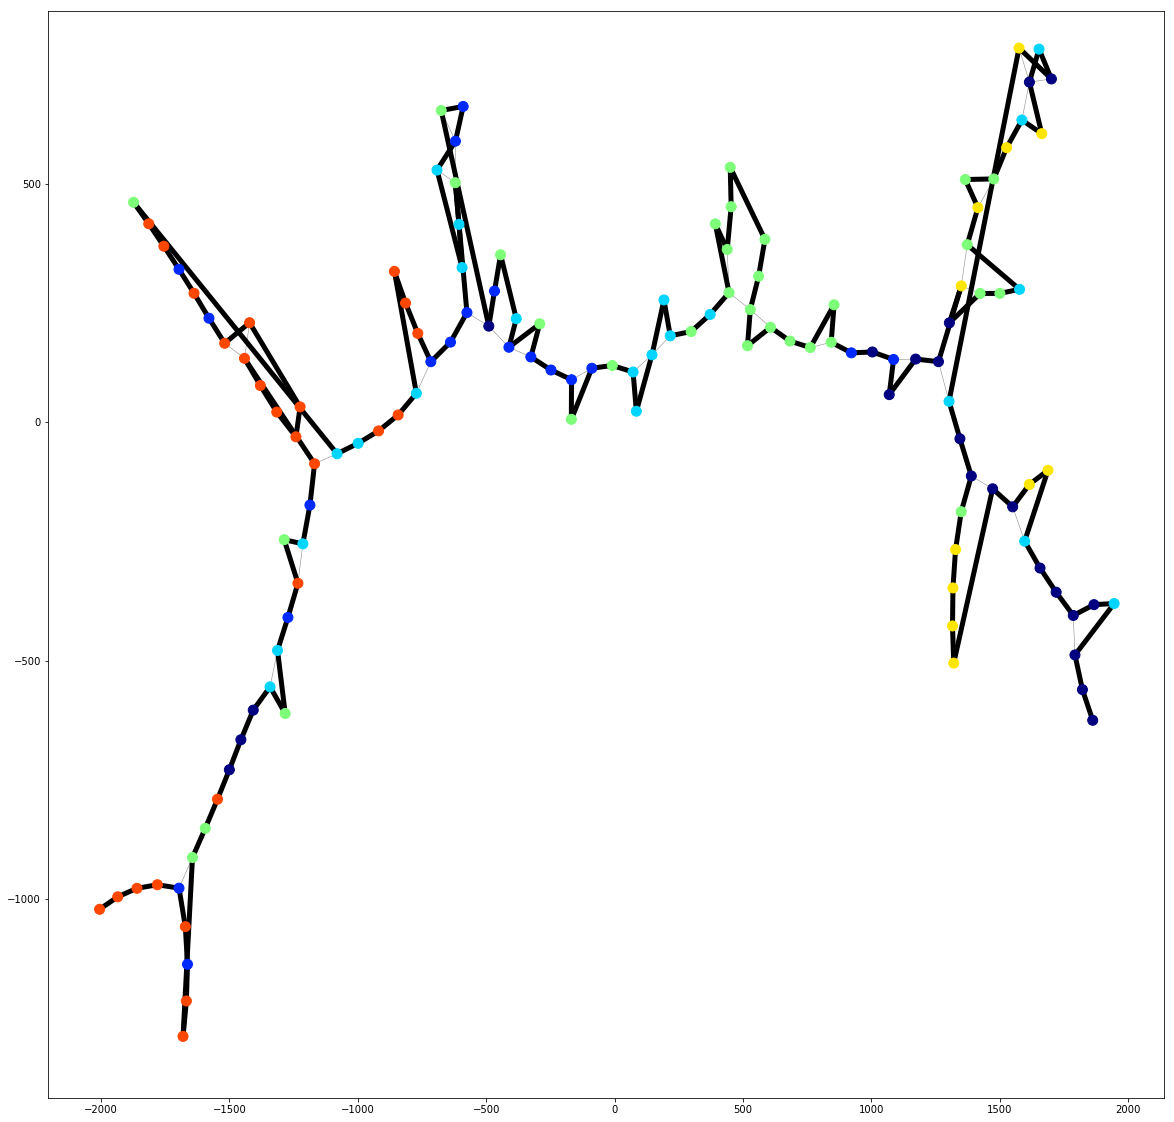

In [1051]:
PTO_coords_Lgr5_OB_IFE = PTO_create_pseudotemporal_ordering_2d(dist_mat_tsne_Lgr5_OB_IFE.copy(), cl_Lgr5_wnd_ctrl_sel)

### Checkpoint

In [1052]:
#saveData_v1(PTO_coords_Lgr5_OB_IFE, path_output, exp_id, 'PTO_coords_Lgr5_OB_IFE')

In [1053]:
PTO_coords_Lgr5_OB_IFE = loadData_v1(path_output, exp_id, 'PTO_coords_Lgr5_OB_IFE', 'Series')

## Cubic spline fitting

In [1054]:
c_sel = cl_Lgr5_wnd_ctrl_sel.index

In [1056]:
PTO_Lgr5_OB_IFE_fitted, PTO_Lgr5_OB_IFE_stats = fit_vgam_v1(np.rint(seq_sel_norm), PTO_coords_Lgr5_OB_IFE[c_sel], genes_sel_IFE_OB, 5)

/Users/simjoo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:63: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/Users/simjoo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:27: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/Users/simjoo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:64: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/Users/simjoo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:65: DeprecationWar

In [1057]:
np.sum(PTO_Lgr5_OB_IFE_stats['Pr(>Chisq)-BH']<0.05)

206

### Checkpoint

In [1061]:
#saveData_v1(PTO_Lgr5_OB_IFE_fitted, path_output, exp_id, 'PTO_Lgr5_OB_IFE_fitted')
#saveData_v1(PTO_Lgr5_OB_IFE_stats, path_output, exp_id, 'PTO_Lgr5_OB_IFE_stats')

In [1062]:
PTO_Lgr5_OB_IFE_fitted = loadData_v1(path_output, exp_id, 'PTO_Lgr5_OB_IFE_fitted', 'DataFrame')
PTO_Lgr5_OB_IFE_stats = loadData_v1(path_output, exp_id, 'PTO_Lgr5_OB_IFE_stats', 'DataFrame')

## Negative binominal regression of pseudotime bins

In [1063]:
def PTO_bin_axis(data, n_bins, bin_range, bin_names):
    
    """
    Divides a pseudotemporal axis into bins.
    -----------
    data: [pd.Series] containing the axis coordinates of m cells.
    n_bins: number [int] of bins.
    bin_range: [tuple] of beginning and end of bin range.
    bin_names: [list] of names for each bin.
    -----------
    returns
    """
    
    #get bin edges
    
    bins = np.histogram(data, n_bins, bin_range)[1]
    
    #digitize
    
    dig = np.digitize(data, bins)
    
    #transform to pd.Series with bin names
    
    output = pd.Series(index = data.index)
    
    for pos,ix in enumerate(data.index):
        
        output.ix[ix] = bin_names[dig[pos]-1]
        
    return bins, output

### Bin data

In [1099]:
c_sel = cl_Lgr5_wnd_ctrl_sel.index

In [1100]:
PTO_coords_Lgr5_OB_IFE[c_sel].max()

122.46368762727622

In [1066]:
PT_bins = PTO_bin_axis(PTO_coords_Lgr5_OB_IFE[c_sel], 5, (0,123), list(range(5)))[1]

/Users/simjoo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:28: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


In [1067]:
Counter(PT_bins)

Counter({0.0: 34, 1.0: 18, 2.0: 24, 3.0: 33, 4.0: 22})

In [1101]:
PT_bins_2 = PTO_bin_axis(PTO_coords_Lgr5_OB_IFE[c_sel], 6, (0,123), list(range(6)))[1]

/Users/simjoo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:28: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


In [1104]:
Counter(PT_bins_2)

Counter({0.0: 29, 1.0: 19, 2.0: 11, 3.0: 30, 4.0: 23, 5.0: 19})

In [1106]:
Counter(PT_bins_2[cl_Lgr5_wnd_ctrl_sel[cl_Lgr5_wnd_ctrl_sel=='ctrl'].index])

Counter({0.0: 15, 1.0: 10})

In [1107]:
PT_bins_2[PT_bins_2==0.0] = 'ctrl'
PT_bins_2[PT_bins_2==1.0] = 'ctrl'

In [1108]:
Counter(PT_bins_2)

Counter({'ctrl': 48, 2.0: 11, 4.0: 23, 5.0: 19, 3.0: 30})

### Checkpoint

In [1110]:
#saveData_v1(PT_bins, path_output, exp_id, 'PT_bins')
#saveData_v1(PT_bins_2, path_output, exp_id, 'PT_bins_2')

In [1111]:
PT_bins = loadData_v1(path_output, exp_id, 'PT_bins_2', 'Series')

## Define parameters

In [1112]:
seq_wnd_IFE_OB_norm = loadData_v1(path_output, exp_id, 'seq_wnd_IFE_OB_norm', 'DataFrame')
sf = loadData_v1(path_output, exp_id, 'sf_wnd_IFE_OB', 'Series')

In [1113]:
cl_Lgr5_wnd_ctrl = loadData_v1(path_output, exp_id, 'cl_Lgr5_wnd_ctrl', 'Series')
cl_Lgr6_wnd_ctrl = loadData_v1(path_output, exp_id, 'cl_Lgr6_wnd_ctrl', 'Series')

In [1114]:
NxK = pd.DataFrame(0, index = return_unique(PT_bins) + ['Lgr6 - IFE','Lgr6 - WF','OB','IFEB'], 
                   columns = list(cl_Lgr5_wnd_ctrl.index) + list(cl_Lgr6_wnd_ctrl.index) + list(cl_epi_1st[cl_epi_1st.isin([2,7])].index))

for gr in return_unique(PT_bins):
    c_sel = PT_bins[PT_bins==gr].index
    NxK.ix[gr, c_sel] = sf[c_sel]
    
c_sel = cl_Lgr6_wnd_ctrl[cl_Lgr6_wnd_ctrl=='ctrl - IFE'].index
NxK.ix['Lgr6 - IFE',c_sel] = sf[c_sel]

c_sel = cl_Lgr6_wnd_ctrl[cl_Lgr6_wnd_ctrl.isin(['5','1'])].index
NxK.ix['Lgr6 - WF',c_sel] = sf[c_sel]

c_sel = cl_epi_1st[cl_epi_1st.isin([2])].index
NxK.ix['IFEB',c_sel] = sf[c_sel]

c_sel = cl_epi_1st[cl_epi_1st.isin([7])].index
NxK.ix['OB',c_sel] = sf[c_sel]

/Users/simjoo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


In [1115]:
NxK.sum(axis=1)

ctrl           36.193627
2.0             9.408331
4.0            24.776343
5.0            19.225033
3.0            34.454944
Lgr6 - IFE    127.815515
Lgr6 - WF      41.299926
OB            171.886588
IFEB          322.654836
dtype: float64

In [1116]:
genes_sel_NBR = list(dropNull_v2(seq_wnd_IFE_OB_norm[NxK.columns], path_input, cutoff_mean = 0.05, drop_markers=False, drop_spikes=False).index)


Dropping unexpressed genes from dataset


In [1117]:
len(genes_sel_NBR)

9442

### Checkpoint

In [1118]:
#saveData_v1(NxK, path_output, exp_id, 'NxK_PT')
#saveData_v1(seq_wnd_IFE_OB.ix[genes_sel_NBR], path_output, exp_id, 'seq_NBR_PT')

## Run model

In [1119]:
#define model
    
model = """
    data {
        int<lower=0> N; # number of outcomes
        int<lower=0> K; # number of predictors
        matrix<lower=0>[N,K] x; # predictor matrix
        int y[N]; # outcomes
    }

    parameters {
        vector<lower=1>[K] beta; # coefficients
        real<lower=0.001> r; # overdispersion
    }

    model {
        vector[N] mu;
        vector[N] rv; 
        
        # priors
        r ~ cauchy(0,1);
        beta ~ pareto(1,1.5);

        # vectorize the overdispersion
        for (n in 1:N) {
                rv[n] <- square(r + 1) - 1;
        }

        #regression
        mu <- x * (beta - 1) + 0.001;
        y ~ neg_binomial(mu ./ rv, 1 / rv[1]);
    }
    """

In [1120]:
NxK = loadData_v1(path_output, exp_id, 'NxK_PT', 'DataFrame')
seq_NBR = loadData_v1(path_output, exp_id, 'seq_NBR_PT', 'DataFrame')

In [78]:
"""
NBR_PT_traces2 = neg_binom_regression_free_input_v2P(model, 
                                                    seq_NBR,
                                                    seq_NBR.index,
                                                    len(NxK.columns), 
                                                    len(NxK.index), 
                                                    NxK, 
                                                    path_output, 
                                                    exp_id, 
                                                    'NBR_PT_traces2',
                                                    2500, 
                                                    dview, 
                                                    iter=275, 
                                                    chains=4, 
                                                    warmup=25,
                                                    n_jobs=4)
"""

"\nNBR_PT_traces = neg_binom_regression_free_input_v2P(model, \n                                                    seq_NBR,\n                                                    seq_NBR.index,\n                                                    len(NxK.columns), \n                                                    len(NxK.index), \n                                                    NxK, \n                                                    path_output, \n                                                    exp_id, \n                                                    'NBR_PT_traces',\n                                                    5000, \n                                                    dview, \n                                                    iter=275, \n                                                    chains=4, \n                                                    warmup=25,\n                                                    n_jobs=4)\n"